# The ABIDE dataset

Nowadays the Autism Spectrum Disorder is an hot topic in research.
The fondamental issue to be assessed is the absence of a Gold Standard methodology for diagnosis evaluation: based on clinical interviews and behavioral assessments.

In order to improve knowledge and discover rules behind ASD, ABIDE Dataset has been borned.

The ABIDE Dataset is a collaborative dataset, multi-sites, containing several kinds of informations: fMRI, sMRi, phenotypic, diagnosis.

This project has been focused on Phenotypic characteristics dealing with the fondamental issue mentioned above.

The ABIDE Dataset has been validated in several papers.
Our reference and starting poin is available here:
https://pubmed.ncbi.nlm.nih.gov/30393630/


In [1]:
import os #to interact to the file system
import numpy as np #Statistics
import pandas as pd #Database Technology <-> Data preproc & Data Analysis
from matplotlib import pyplot as plt #Visualization
import seaborn as sns #Visualization
import missingno as msno
import random 
from sklearn.preprocessing import RobustScaler #scikit-learn -> ML
import OurFunctions as of #saperated collection
import Optimization as opt

#seed for random processes
seed = 42
np.random.seed(seed)

## Load the dataset

In [2]:
ASD_phenotypic_original = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_phenotypic.csv'))

# DATA EXPLORATION

Visualization of the overall dataset

In [3]:
ASD_phenotypic_original

,SITE_ID,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,...,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI
0,CALTECH,51456,1,4,55.40,1,R,NaN,126.0,118.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
1,CALTECH,51457,1,4,22.90,1,Ambi,NaN,107.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
2,CALTECH,51458,1,1,39.20,1,R,NaN,93.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
3,CALTECH,51459,1,1,22.80,1,R,NaN,106.0,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
4,CALTECH,51460,1,1,34.60,2,Ambi,NaN,133.0,135.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,YALE,50624,1,3,11.08,2,R,NaN,90.0,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
1108,YALE,50625,1,3,7.00,1,L,NaN,99.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
1109,YALE,50626,1,3,11.08,1,L,NaN,61.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
1110,YALE,50627,1,3,9.50,2,R,NaN,88.0,103.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN


The dataset contains 1112 subjects and has 74 features.

 At first look, it is noticeable the presence of categorical and numerical features and missing values. Moreover, we can see the presence of the categories DX_GROUP and DSM_IV_TR, that are described from the ABIDE dataset legend as diagnostic, so we will further remove them from the dataset for the model predictor construction. 
 We can also proceed deleting the feature EYE_STATUS_AT_SCAN, because it deals with the eyes opening by the subject  during the fMRI, thus it is meaningless for our purposes.

DX_GROUP and DSM_IV_TR are our targets.
DX_GROUP contains info about ASD detection (yes/no). 
DSM_IV_TR specifyes which kind of autism, if there is.
However, in our investigation, we are interested only in evaluating the presence or not of the disorder, so we will not consider the information in DSM_IV_TR.

In order to understand the balancing of our dataset, we check the target feature: 'DX_GROUP'. 

1 | Autism detected

2 | Controls

Class count DX_GROUP:
DX_GROUP
2    573
1    539
Name: count, dtype: int64


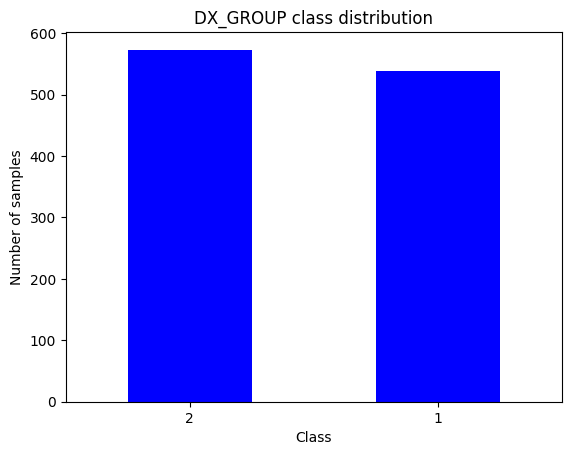


Class Proportion DX_GROUP:
DX_GROUP
2    0.515288
1    0.484712
Name: proportion, dtype: float64


In [4]:
of.evaluate_balancing(ASD_phenotypic_original)

DX_GROUP is balanced enought.

Now, to have a better view of the information contained in the dataset we display the names of the features and the respective types and quantity of non-null values.

In [5]:
ASD_phenotypic_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 74 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SITE_ID                          1112 non-null   object 
 1   SUB_ID                           1112 non-null   int64  
 2   DX_GROUP                         1112 non-null   int64  
 3   DSM_IV_TR                        1112 non-null   int64  
 4   AGE_AT_SCAN                      1112 non-null   float64
 5   SEX                              1112 non-null   int64  
 6   HANDEDNESS_CATEGORY              797 non-null    object 
 7   HANDEDNESS_SCORES                370 non-null    float64
 8   FIQ                              1077 non-null   float64
 9   VIQ                              935 non-null    float64
 10  PIQ                              953 non-null    float64
 11  FIQ_TEST_TYPE                    947 non-null    object 
 12  VIQ_TEST_TYPE       

In [6]:
ASD_phenotypic_original.describe(include = 'object').T

,count,unique,top,freq
SITE_ID,1112,20,NYU,184
HANDEDNESS_CATEGORY,797,6,R,693
FIQ_TEST_TYPE,947,13,WASI,551
VIQ_TEST_TYPE,834,14,WASI,508
PIQ_TEST_TYPE,853,15,WASI,508
COMORBIDITY,64,43,ADHD Inattentive,7
CURRENT_MED_STATUS,817,4,0,673
MEDICATION_NAME,157,103,0,24


As we can see, there is a huge amount of missing values. 

In order to have a better view of the distribution of the null values, we check the presence of missing values catalogated as None or numpy.NaN

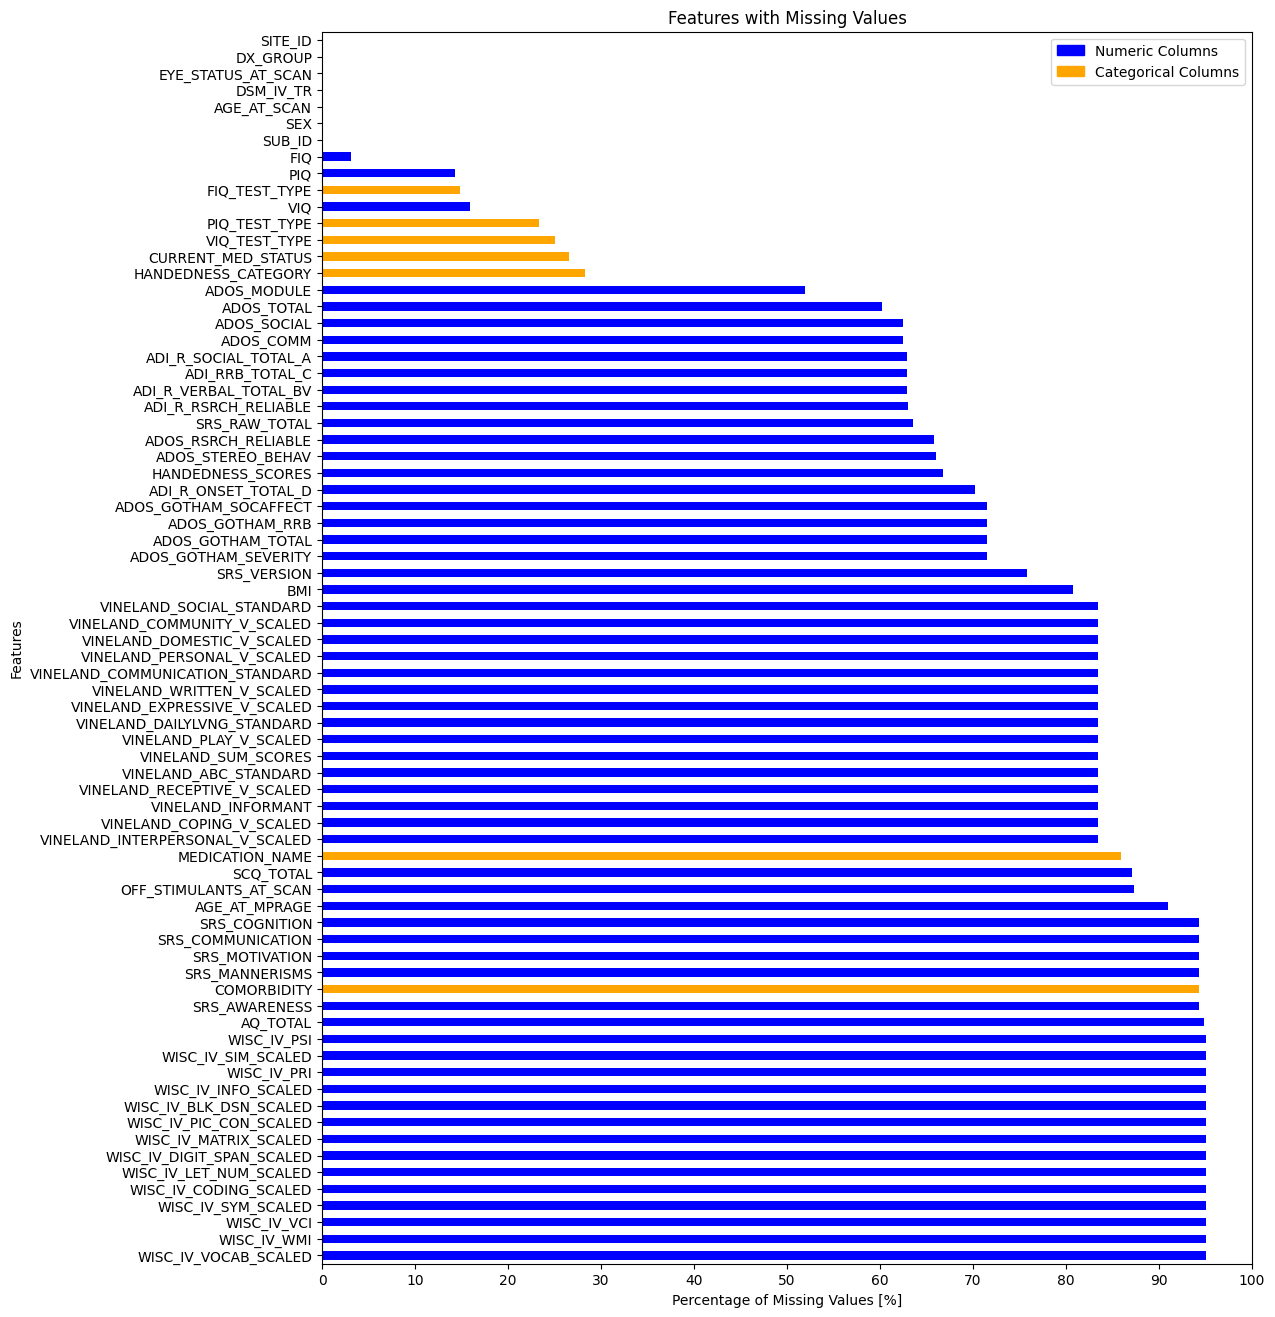

In [7]:
# Count of the missing values

ASD_phenotypic_original, percent_missing = of.count_missing_value(ASD_phenotypic_original)

# We implemented a function "select_columns", that is able to define wich columns are numerical
# and which ones are categorical (also redefine the objects as categorical in the dataset)
numeric_columns, categorical_columns, ASD_phenotypic_original = of.select_columns(ASD_phenotypic_original)

# We plot the distribution of missing values, with the specification of numeric and categorical columns
of.plot_missing_values(percent_missing, numeric_columns, legend=True)



For the majority of the features the amount of missing values is not depreciable, so we can say that the information that is stored in the feature is not enough to create a reliable classier/cluster algortihm based on it. The same comment can be done for the subjects. We need to work on a dataset that has a maximum of 10% of missing values per feature, so we need to clean this in some way.

Now let's have a look on the general statistics for the numerical attributes.

In [8]:
ASD_phenotypic_original.describe()

,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,ADI_R_SOCIAL_TOTAL_A,...,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI
count,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,370.000000,1077.000000,935.000000,953.000000,412.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,1112.000000,101.000000,214.000000
mean,50752.684353,1.515288,-646.819245,17.048864,1.147482,-102.560892,-238.854968,-86.757219,-126.663169,-807.024272,...,11.636364,9.909091,11.545455,10.127273,10.363636,8.763636,9.890909,1.312050,-86.176535,-5597.902757
std,447.680666,0.499991,2461.828856,8.036419,0.354745,1273.177790,1841.858322,1389.584584,1518.469557,2760.138808,...,3.014555,3.187201,2.651472,3.232099,2.914610,2.821634,2.753266,0.463539,996.228820,4984.307763
min,50002.000000,1.000000,-9999.000000,6.470000,1.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,4.000000,3.000000,7.000000,2.000000,2.000000,4.000000,1.000000,1.000000,-9999.000000,-9999.000000
25%,50354.750000,1.000000,0.000000,11.658575,1.000000,48.000000,98.000000,97.000000,96.000000,14.000000,...,10.000000,7.000000,10.000000,7.500000,9.500000,7.000000,8.000000,1.000000,11.250000,-9999.000000
50%,50724.500000,2.000000,0.000000,14.660000,1.000000,75.000000,108.000000,108.000000,107.000000,20.000000,...,11.000000,11.000000,11.000000,10.000000,11.000000,9.000000,10.000000,1.000000,12.900000,-9999.000000
75%,51153.250000,2.000000,1.000000,20.085000,1.000000,91.000000,119.000000,119.000000,117.000000,24.000000,...,13.000000,12.000000,12.500000,12.500000,12.000000,10.500000,12.000000,2.000000,14.440000,18.817500
max,51607.000000,2.000000,4.000000,64.000000,2.000000,100.000000,148.000000,180.000000,157.000000,30.000000,...,19.000000,15.000000,19.000000,17.000000,14.000000,15.000000,16.000000,2.000000,17.940000,35.430000


We can notice the presence of "-9999" as minimum value for different features, a value that is commonly used to denote missing data or values out of range, so it should be better to consider them as NaN.

Now that we have an overall view of the dataset, let's start to work on it in order to clean it.

# DATA CLEANING

First of all, we decided to apart the feature DX_GROUP that give the diagnosis of the subjects, as our control label. As written above, DSM_IV_TR it is irrelevant for our purpose.
The same for EYE_STATUS_AT_SCAN. These two features are dropped.

In [9]:


ASD_phenotypic = ASD_phenotypic_original.drop(columns=['DSM_IV_TR','EYE_STATUS_AT_SCAN'])



Also we decide to drop SUB_ID, as it only store the information about the ID of the subject. But before doing this, we check if there aren't replicated subjects. Then, since we don't find any duplicate, we simply drop the column.

In [10]:
# Check if there are duplicate values in the 'SUB_ID' column
duplicate_ids = ASD_phenotypic['SUB_ID'].duplicated(keep=False)

# Get the unique duplicate IDs
unique_duplicate_ids = ASD_phenotypic.loc[duplicate_ids, 'SUB_ID'].unique()

#Drop column if there aren't duplicates
if len(unique_duplicate_ids) == 0:
    ASD_phenotypic = ASD_phenotypic.drop(columns=['SUB_ID'])
    print("SUB_ID has been dropped")
else:
    print("There are replicated values:" + str(unique_duplicate_ids))
    

SUB_ID has been dropped


In order to have a real count of the amount of missing values per feature, we change the -9999 values present in the overall data to np.NaN (we can make this because we know from the datasheets that -9999 is a value out of range for all the features).

In [11]:
for column in ASD_phenotypic:
    
    # Replace -9999 and "-9999" with NaN
    ASD_phenotypic[column] = ASD_phenotypic[column].replace(['-9999', -9999], np.NaN)
    

We also notice that there are two features ADI_R_RSRCH_RELIABLE and ADOS_RSRCH_RELIABLE: these are relating the personal that took the tests, indicating if he/she is a trained professional or not.
We use this information to evaluate the reliability of the score-tests. In order to avoid the inclusion of not reliable informations, we decide to eliminate the subjects that has a 0 in both categories (not reliable), while if the value is 1 or missed, we maintain the subject.

In [12]:
# Create a mask for rows to keep
filter = (ASD_phenotypic['ADI_R_RSRCH_RELIABLE'] != 0) | (ASD_phenotypic['ADOS_RSRCH_RELIABLE'] != 0)

# Calculate the number of subjects to delete
deleted_subjects = len(ASD_phenotypic) - filter.sum()

# Apply the mask to both DataFrames
ASD_phenotypic= ASD_phenotypic[filter]

# Print the number of subjects deleted
print("Number of subjects deleted:", deleted_subjects)

ASD_phenotypic = ASD_phenotypic.drop(columns=['ADI_R_RSRCH_RELIABLE','ADOS_RSRCH_RELIABLE'])

Number of subjects deleted: 26


In [13]:
ASD_phenotypic

,SITE_ID,DX_GROUP,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,FIQ_TEST_TYPE,...,WISC_IV_INFO_SCALED,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,AGE_AT_MPRAGE,BMI
0,CALTECH,1,55.40,1,R,NaN,126.0,118.0,128.0,WASI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CALTECH,1,22.90,1,Ambi,NaN,107.0,119.0,93.0,WASI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CALTECH,1,39.20,1,R,NaN,93.0,80.0,108.0,WASI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CALTECH,1,22.80,1,R,NaN,106.0,94.0,118.0,WASI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CALTECH,1,34.60,2,Ambi,NaN,133.0,135.0,122.0,WASI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,YALE,1,11.08,2,R,NaN,90.0,91.0,89.0,DAS_II_SA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1108,YALE,1,7.00,1,L,NaN,99.0,90.0,98.0,DAS_II_SA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1109,YALE,1,11.08,1,L,NaN,61.0,66.0,60.0,DAS_II_SA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1110,YALE,1,9.50,2,R,NaN,88.0,103.0,84.0,DAS_II_SA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In order to complete the cleaning on our starting dataset:

- Displaying the distribution of missing values
- Menaging our dataset with the purpose to achieve at a cleaned one with two conditions:
    
    - 10 % of NaN per feature
    - at least 1/4 of subjects involved
    - balancing of dataset (max 70/30 %)

<Axes: >

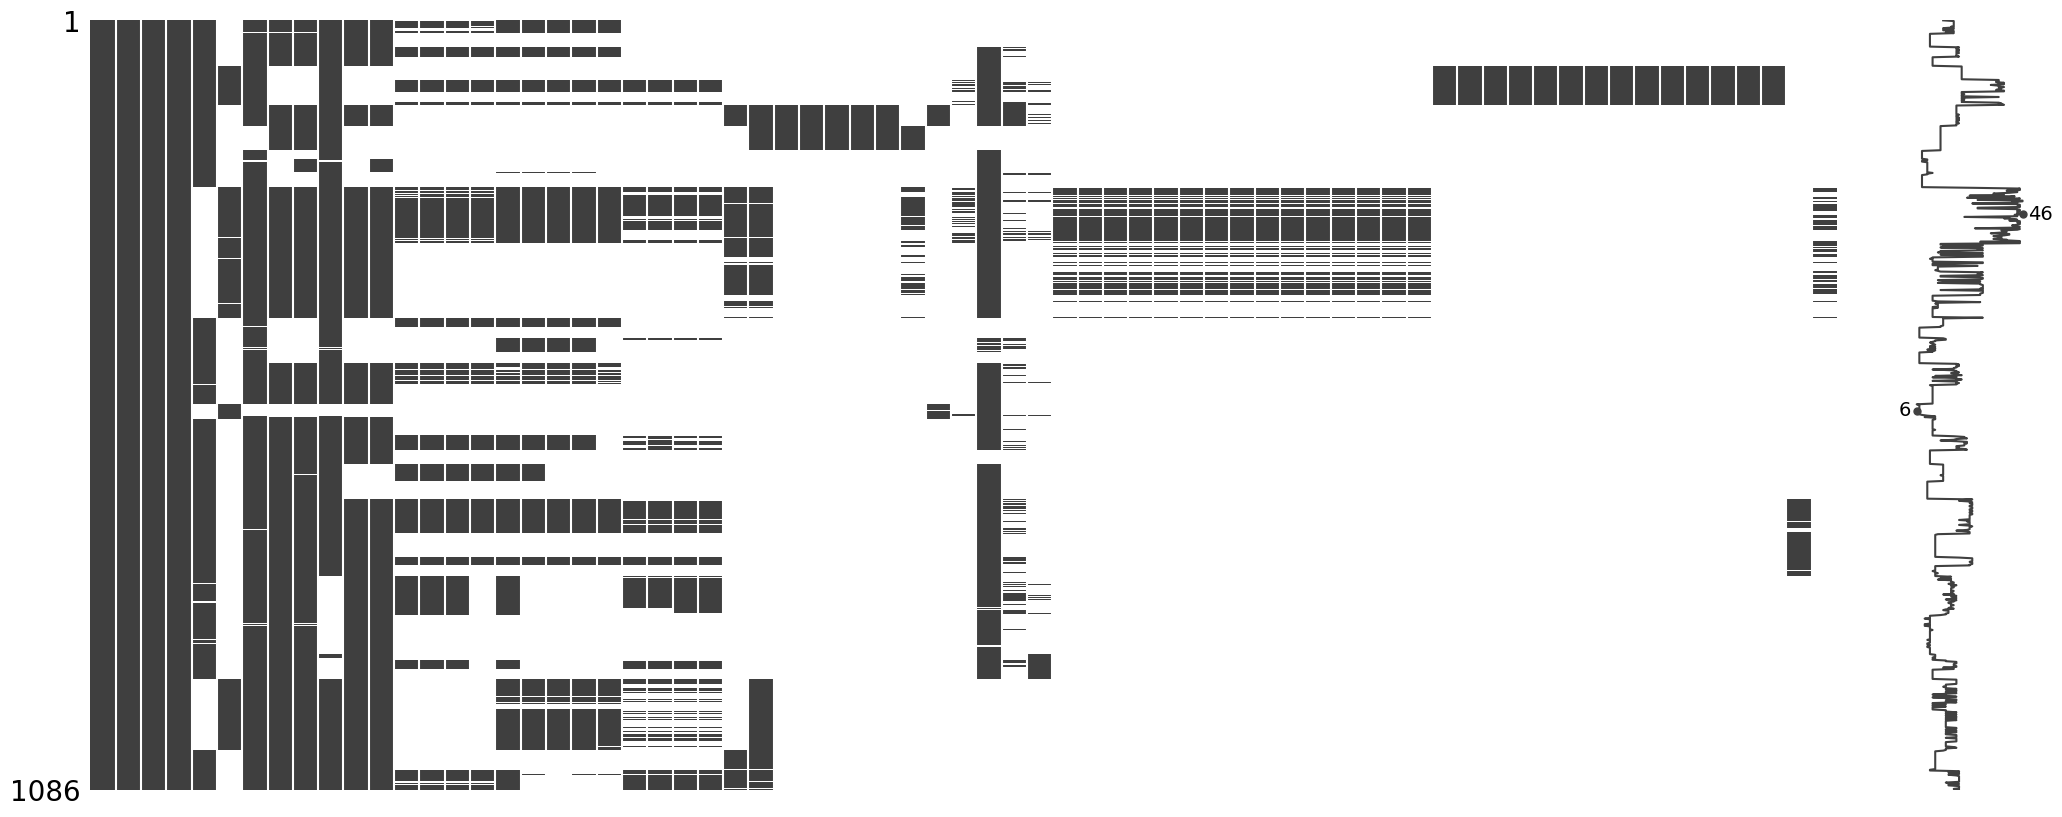

In [14]:
#Visualizzazione dei missing values
msno.matrix(ASD_phenotypic)

According to our aim, following the pipeline of reference paper, we create an alghoritm with boundary contitions already mentioned. Moreover, we force the presence of key features.  

In [15]:
# Key Features to mantain
key_features = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_VERBAL_TOTAL_BV', 'ADOS_TOTAL']


# Clining function on dataset
ASD_phenotypic_cleaned = opt.remove_high_missing(ASD_phenotypic, key_features, balance_column='DX_GROUP', min_subjects=200, max_missing_percentage=10)

# Print DataFrame cleaned 
ASD_phenotypic_cleaned

Feature removed: AQ_TOTAL
Actual percentage of missing values: 73.00%
Number of subjects remaining: 1086
Feature removed: WISC_IV_VCI
Actual percentage of missing values: 72.67%
Number of subjects remaining: 1086
Feature removed: WISC_IV_PRI
Actual percentage of missing values: 72.33%
Number of subjects remaining: 1086
Feature removed: WISC_IV_WMI
Actual percentage of missing values: 71.99%
Number of subjects remaining: 1086
Feature removed: WISC_IV_PSI
Actual percentage of missing values: 71.63%
Number of subjects remaining: 1086
Feature removed: WISC_IV_SIM_SCALED
Actual percentage of missing values: 71.26%
Number of subjects remaining: 1086
Feature removed: WISC_IV_VOCAB_SCALED
Actual percentage of missing values: 70.88%
Number of subjects remaining: 1086
Feature removed: WISC_IV_INFO_SCALED
Actual percentage of missing values: 70.48%
Number of subjects remaining: 1086
Feature removed: WISC_IV_BLK_DSN_SCALED
Actual percentage of missing values: 70.07%
Number of subjects remaining: 1

,SITE_ID,DX_GROUP,AGE_AT_SCAN,SEX,FIQ,VIQ,PIQ,FIQ_TEST_TYPE,VIQ_TEST_TYPE,PIQ_TEST_TYPE,ADI_R_VERBAL_TOTAL_BV,ADOS_TOTAL
0,CALTECH,1,55.40,1,126.0,118.0,128.0,WASI,WASI,WASI,NaN,9.0
1,CALTECH,1,22.90,1,107.0,119.0,93.0,WASI,WASI,WASI,17.0,8.0
2,CALTECH,1,39.20,1,93.0,80.0,108.0,WASI,WASI,WASI,18.0,20.0
3,CALTECH,1,22.80,1,106.0,94.0,118.0,WASI,WASI,WASI,12.0,12.0
4,CALTECH,1,34.60,2,133.0,135.0,122.0,WASI,WASI,WASI,11.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1107,YALE,1,11.08,2,90.0,91.0,89.0,DAS_II_SA,DAS_II_SA,DAS_II_SA,10.0,NaN
1108,YALE,1,7.00,1,99.0,90.0,98.0,DAS_II_SA,DAS_II_SA,DAS_II_SA,23.0,NaN
1109,YALE,1,11.08,1,61.0,66.0,60.0,DAS_II_SA,DAS_II_SA,DAS_II_SA,24.0,NaN
1110,YALE,1,9.50,2,88.0,103.0,84.0,DAS_II_SA,DAS_II_SA,DAS_II_SA,11.0,NaN


Checking Missing Values for features and subjects

In [16]:
ASD_phenotypic_cleaned.isna().sum()


SITE_ID                    0
DX_GROUP                   0
AGE_AT_SCAN                0
SEX                        0
FIQ                        1
VIQ                        0
PIQ                        0
FIQ_TEST_TYPE             66
VIQ_TEST_TYPE             23
PIQ_TEST_TYPE             23
ADI_R_VERBAL_TOTAL_BV    351
ADOS_TOTAL               337
dtype: int64

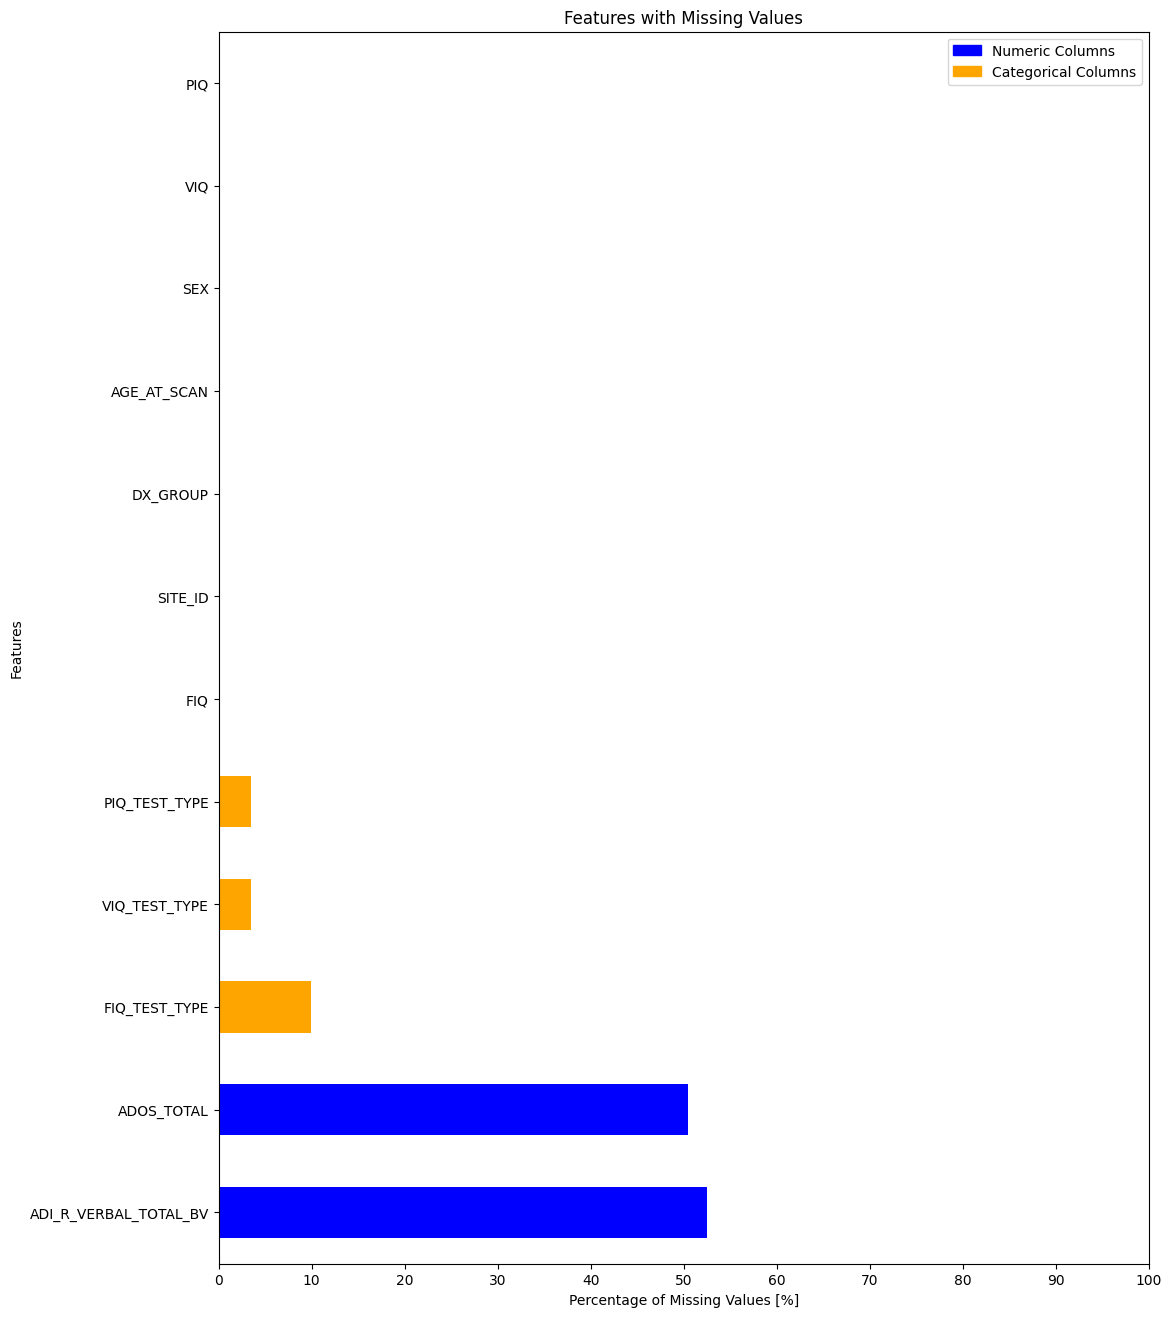

In [17]:
# Count of the missing values
ASD_phenotypic_cleaned, percent_missing = of.count_missing_value(ASD_phenotypic_cleaned)
numeric_columns, categorical_columns, ASD_phenotypic_cleaned = of.select_columns(ASD_phenotypic_cleaned)

of.plot_missing_values(percent_missing, numeric_columns, legend=True)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


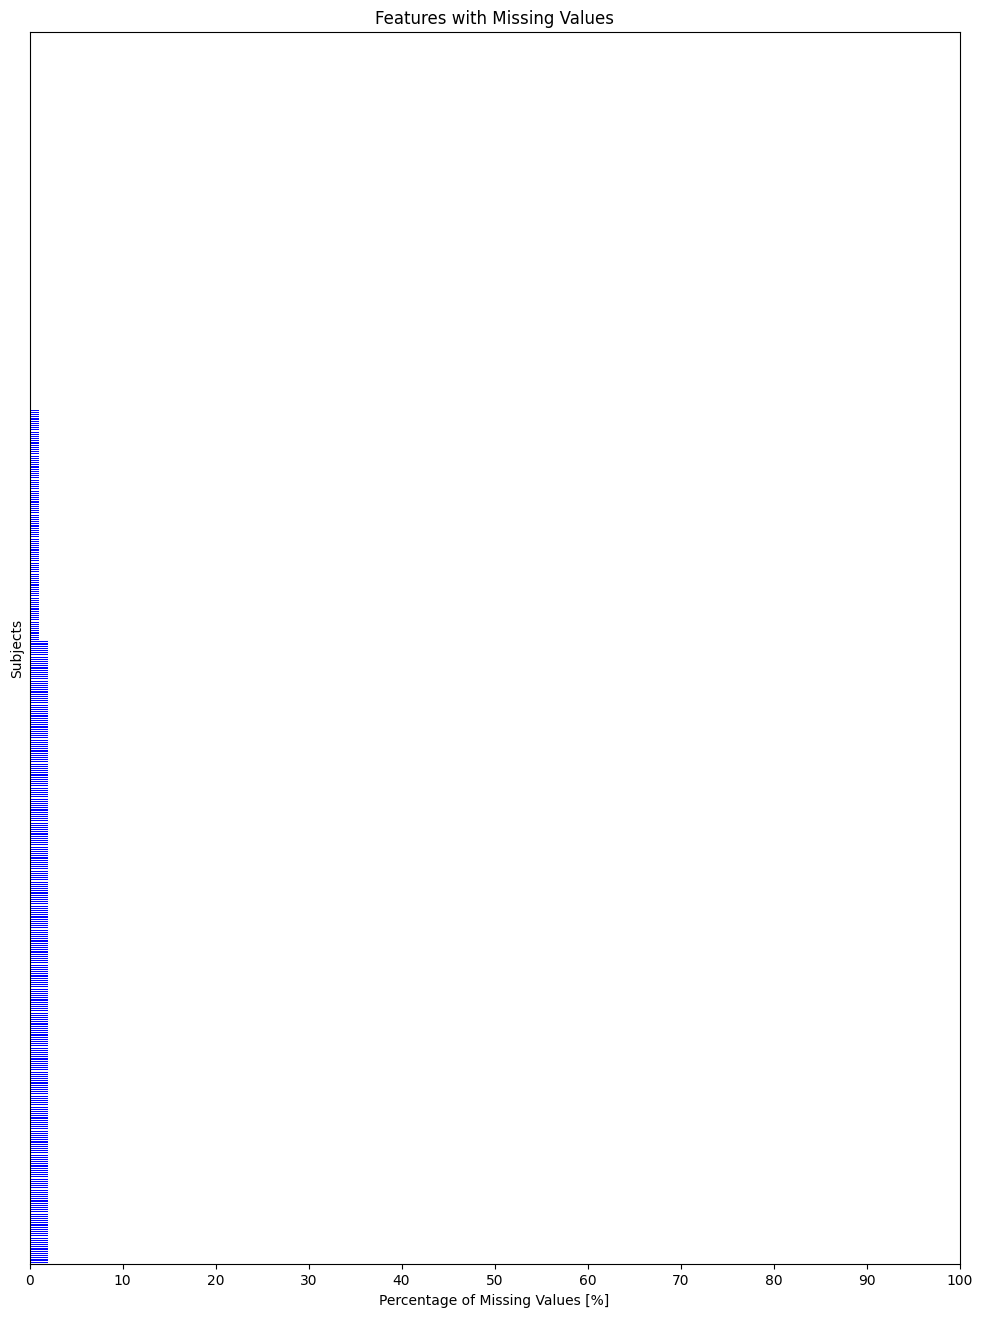

In [18]:
# Evaluation of missing value for subject instead of for feature
nan_values_per_subject = ASD_phenotypic_cleaned.T.isna().sum()

# Ording of missing values
subjects_with_nan_sorted = nan_values_per_subject.sort_values(ascending=False)


of.plot_missing_values(subjects_with_nan_sorted, nan_values_per_subject, legend=False)
plt.ylabel('Subjects')
plt.yticks([])
plt.show()

Checking the balancing

Class count DX_GROUP:
DX_GROUP
1    403
2    265
Name: count, dtype: int64


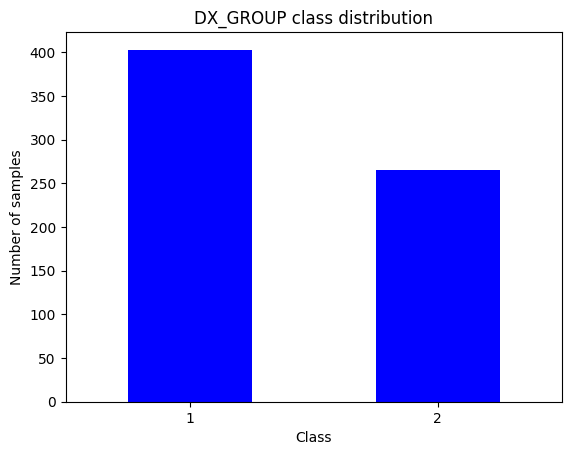


Class Proportion DX_GROUP:
DX_GROUP
1    0.603293
2    0.396707
Name: proportion, dtype: float64


In [19]:
of.evaluate_balancing(ASD_phenotypic_cleaned)

The goal has been achieved in part. Since that we want to mantain ADI_R_VERBAL_TOTAL_BV', 'ADOS_TOTAL

In [20]:
# Detect features
features_to_check = ['ADI_R_VERBAL_TOTAL_BV', 'ADOS_TOTAL']

# Evaluate number of subjects with missing values for DX_GROUP
missing_counts = ASD_phenotypic_cleaned[features_to_check + ['DX_GROUP']].isna().groupby(ASD_phenotypic_cleaned['DX_GROUP']).sum()

# Evaluate total number of subjects for each DX_GROUP
total_counts = ASD_phenotypic_cleaned['DX_GROUP'].value_counts()

# Print results
missing_counts_df = pd.DataFrame({
    'Missing_ADI_R_VERBAL_TOTAL_BV': missing_counts['ADI_R_VERBAL_TOTAL_BV'],
    'Missing_ADOS_TOTAL': missing_counts['ADOS_TOTAL'],
    'Total_Subjects': total_counts
})

print(missing_counts_df)


          Missing_ADI_R_VERBAL_TOTAL_BV  Missing_ADOS_TOTAL  Total_Subjects
DX_GROUP                                                                   
1                                    86                 104             403
2                                   265                 233             265


In [21]:
# Filters out autistic subjects (DX_GROUP = 1) with missing values in the specified features
missing_autistic = ASD_phenotypic_cleaned[(ASD_phenotypic_cleaned['DX_GROUP'] == 1) & (ASD_phenotypic_cleaned[features_to_check].isna().any(axis=1))]

# Filters non-autistic subjects (DX_GROUP = 2) with missing values in the specified features
missing_non_autistic = ASD_phenotypic_cleaned[(ASD_phenotypic_cleaned['DX_GROUP'] == 2) & (ASD_phenotypic_cleaned[features_to_check].isna().any(axis=1))]
# Ottieni gli indici dei soggetti autistici con valori mancanti
indices_to_drop = missing_autistic.index

# Rimuovi i soggetti autistici dal DataFrame ASD_phenotypic_cleaned
ASD_phenotypic_cleaned = ASD_phenotypic_cleaned.drop(index=indices_to_drop)

Class count DX_GROUP:
DX_GROUP
2    265
1    229
Name: count, dtype: int64


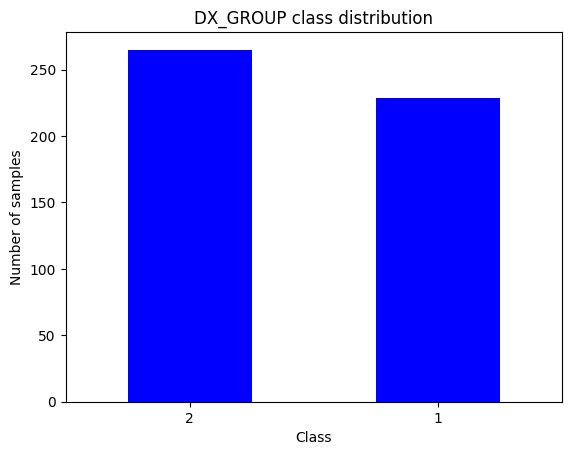


Class Proportion DX_GROUP:
DX_GROUP
2    0.536437
1    0.463563
Name: proportion, dtype: float64


In [22]:
of.evaluate_balancing(ASD_phenotypic_cleaned)

In [23]:

# Definisci il valore soglia del 25% per i valori mancanti
desired_missing_percentage = 25


cleaned_df = opt.optimization_rules(ASD_phenotypic_cleaned,features_to_check,desired_missing_percentage)



      SITE_ID  DX_GROUP  AGE_AT_SCAN  SEX    FIQ    VIQ    PIQ FIQ_TEST_TYPE  \
1     CALTECH         1        22.90    1  107.0  119.0   93.0          WASI   
2     CALTECH         1        39.20    1   93.0   80.0  108.0          WASI   
3     CALTECH         1        22.80    1  106.0   94.0  118.0          WASI   
4     CALTECH         1        34.60    2  133.0  135.0  122.0          WASI   
5     CALTECH         1        37.70    1   99.0  111.0   84.0          WASI   
...       ...       ...          ...  ...    ...    ...    ...           ...   
1077     YALE         2        15.75    2  105.0  126.0   82.0     DAS_II_SA   
1078     YALE         2        14.17    1  103.0   92.0  103.0     DAS_II_SA   
1080     YALE         2        14.00    1  120.0  127.0  114.0     DAS_II_SA   
1081     YALE         2         8.42    2  119.0  112.0  120.0     DAS_II_SA   
1090     YALE         1        17.17    1  141.0  143.0  120.0     DAS_II_SA   

     VIQ_TEST_TYPE PIQ_TEST_TYPE  ADI_R

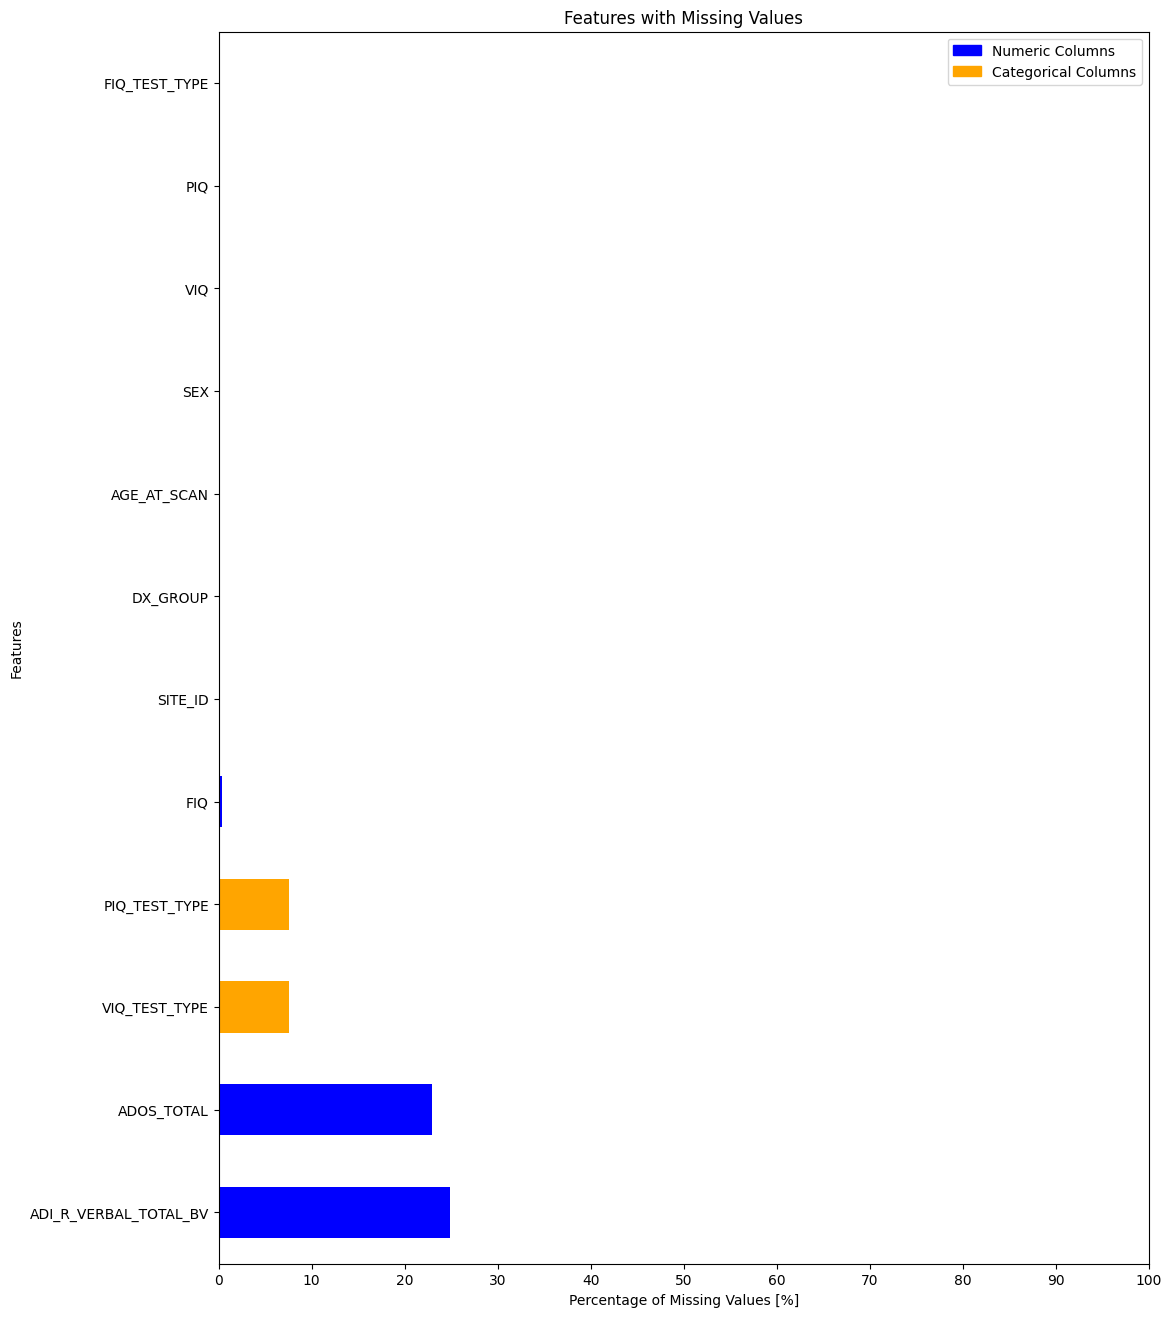

In [24]:
# Count of the missing values

cleaned_df,percent_missing = of.count_missing_value(cleaned_df)

numeric_columns, categorical_columns, cleaned_df = of.select_columns(cleaned_df)

of.plot_missing_values(percent_missing, numeric_columns, legend=True)



Class count DX_GROUP:
DX_GROUP
1    229
2     76
Name: count, dtype: int64


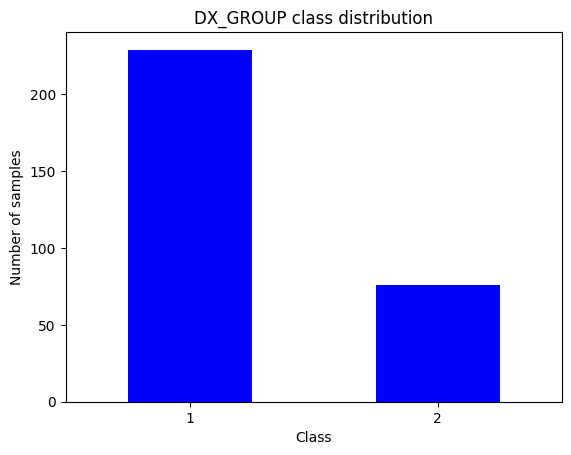


Class Proportion DX_GROUP:
DX_GROUP
1    0.75082
2    0.24918
Name: proportion, dtype: float64


In [25]:
of.evaluate_balancing(cleaned_df)

In [26]:

# Store them in a new dataset called ASD_clinical
ASD_clinical = cleaned_df[['DX_GROUP']]
# Drop  columns DX_GROUP and storage it apart 
ASD_phenotypic = cleaned_df.drop(columns=['DX_GROUP'])



In [27]:
ASD_phenotypic.head().T

,1,2,3,4,5
SITE_ID,CALTECH,CALTECH,CALTECH,CALTECH,CALTECH
AGE_AT_SCAN,22.9,39.2,22.8,34.6,37.7
SEX,1,1,1,2,1
FIQ,107.0,93.0,106.0,133.0,99.0
VIQ,119.0,80.0,94.0,135.0,111.0
PIQ,93.0,108.0,118.0,122.0,84.0
FIQ_TEST_TYPE,WASI,WASI,WASI,WASI,WASI
VIQ_TEST_TYPE,WASI,WASI,WASI,WASI,WASI
PIQ_TEST_TYPE,WASI,WASI,WASI,WASI,WASI
ADI_R_VERBAL_TOTAL_BV,17.0,18.0,12.0,11.0,15.0


# Data Distribution

We want to understand how our features are distributed, in order to know which kind of normalization of the data is more suitable and if we may need to proceed with outlier detection in classification phase.

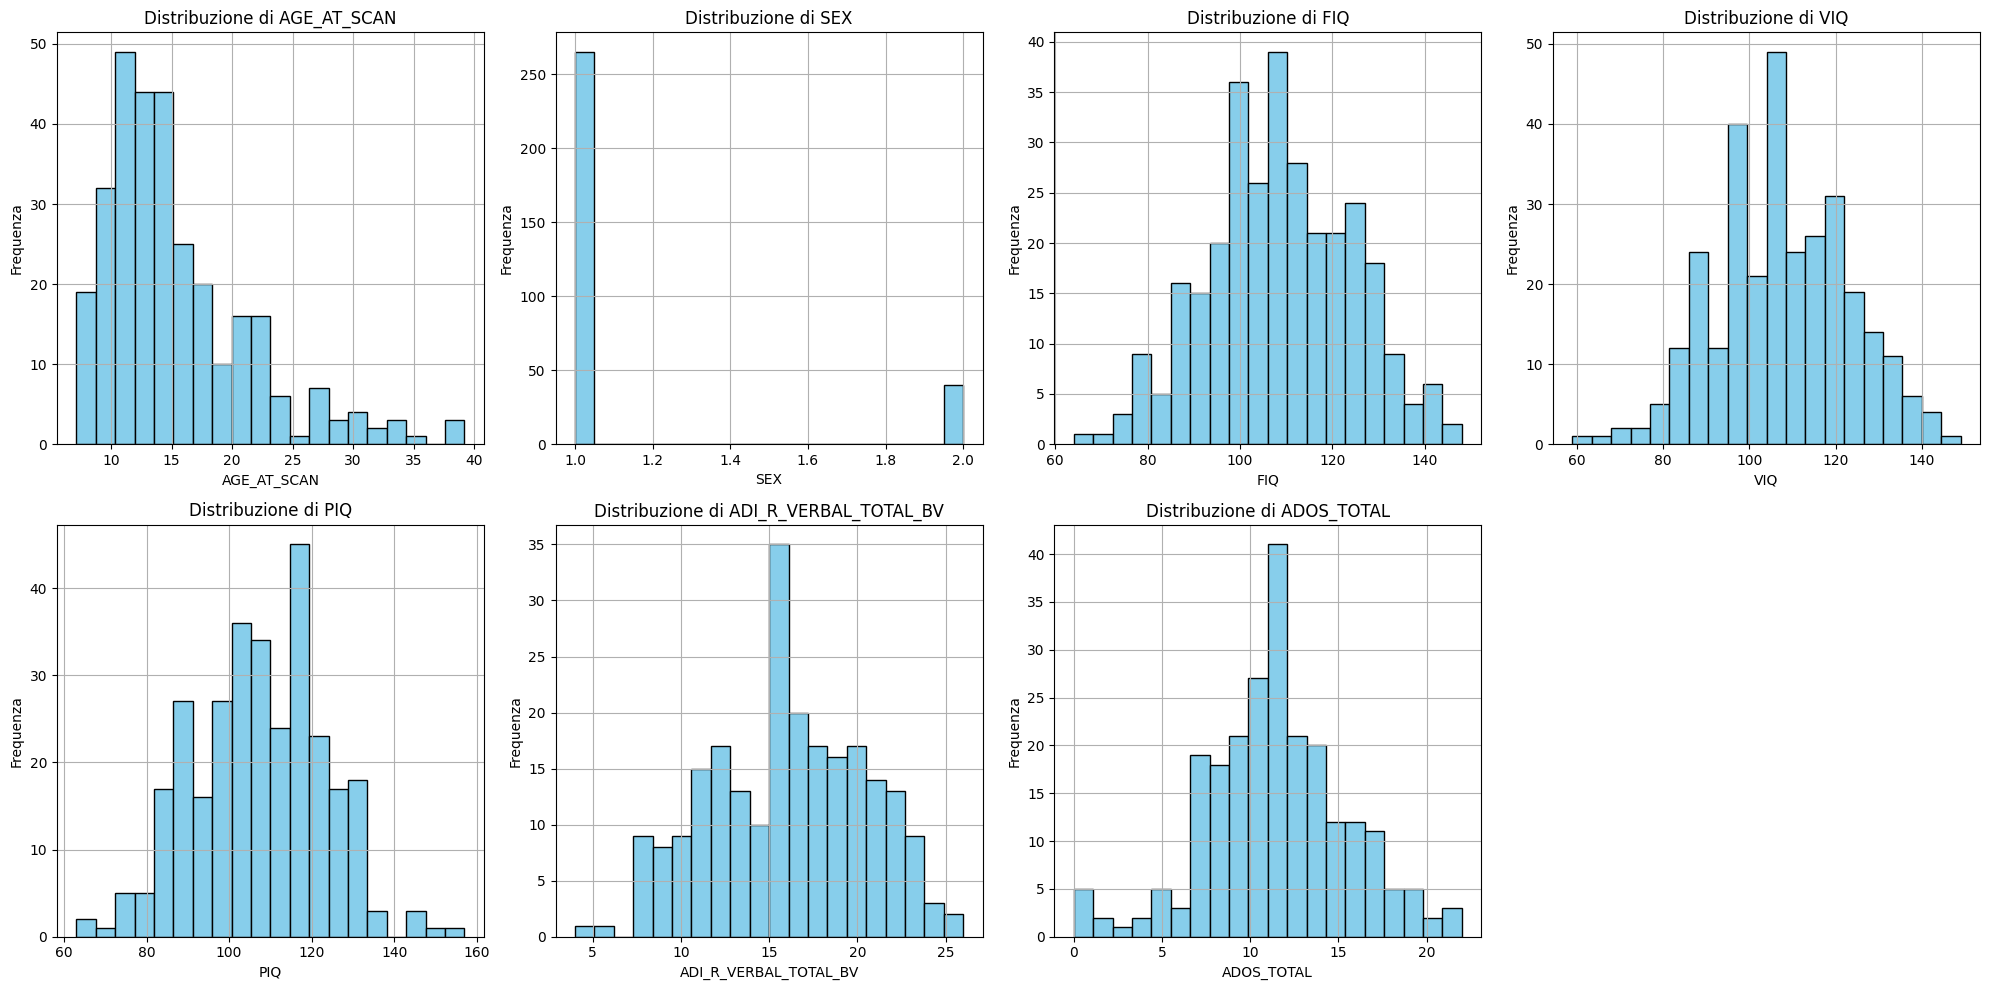

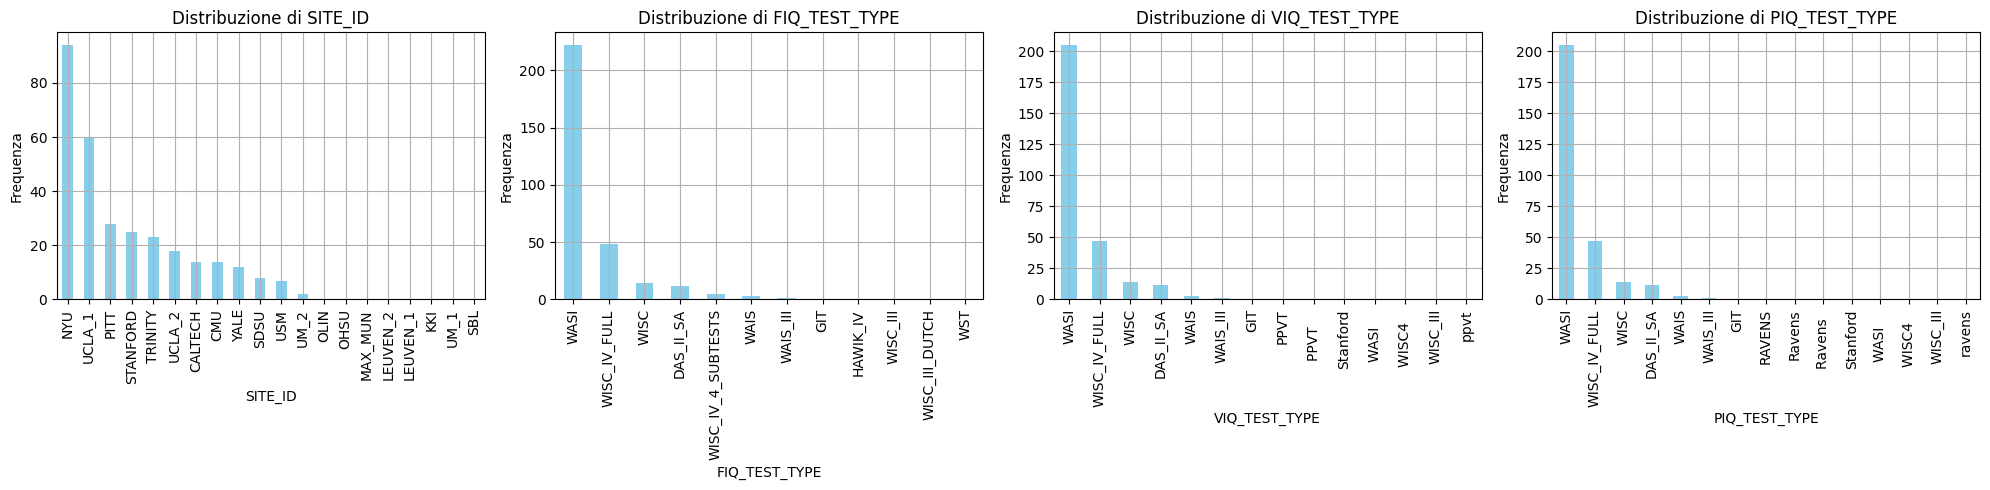

In [28]:
# Plot distribution of features
of.plot_distributions(ASD_phenotypic)

Disucussing graph's results:
We notice the presence of possible outliers per feature. Thus, we quantify the fraction in the entire dataset, in order to take in consideration this element in our future analysis (Outlier detection in classification). 

In [29]:
thresholds = {
    'AGE_AT_SCAN': [{'threshold': 30, 'rule': 'greater'}],
    'FIQ': [
        {'threshold': 145, 'rule': 'greater'},
        {'threshold': 70, 'rule': 'less'}
    ],
     'VIQ': [
        {'threshold': 145, 'rule': 'greater'},
        {'threshold': 70, 'rule': 'less'}
    ],
    
    'PIQ': [
        {'threshold': 140, 'rule': 'greater'},
        {'threshold': 70, 'rule': 'less'}
    ],
    'ADI_R_VERBAL_TOTAL_BV': [{'threshold': 6, 'rule': 'less'}]
}


In [30]:
# Count number of outliers per feature
outlier_counts = {}
total_samples = len(ASD_phenotypic)

for feature, rules in thresholds.items():
    outlier_count = 0
    for rule in rules:
        threshold = rule['threshold']
        comparison = rule['rule']
        if comparison == 'greater':
            outlier_count += (ASD_phenotypic[feature] > threshold).sum()
        elif comparison == 'less':
            outlier_count += (ASD_phenotypic[feature] < threshold).sum()
    outlier_counts[feature] = outlier_count

# % outliers per feature
outlier_percentages = {feature: (count / total_samples) * 100 for feature, count in outlier_counts.items()}

# Print results
for feature, percentage in outlier_percentages.items():
    print(f'Feature: {feature}, Outlier Percentage: {percentage:.2f}%')


Feature: AGE_AT_SCAN, Outlier Percentage: 3.61%
Feature: FIQ, Outlier Percentage: 0.98%
Feature: VIQ, Outlier Percentage: 0.98%
Feature: PIQ, Outlier Percentage: 2.30%
Feature: ADI_R_VERBAL_TOTAL_BV, Outlier Percentage: 0.33%


In [31]:
outlier_counts

{'AGE_AT_SCAN': 11, 'FIQ': 3, 'VIQ': 3, 'PIQ': 7, 'ADI_R_VERBAL_TOTAL_BV': 1}

## CORRELATION ANALYSIS

In order to procced in our data exploration, we want to perform Correlation Analysis.

We need to normalize the data to make comparisons.

## Normalization

In [32]:

# Columns selection
numeric_columns = ASD_phenotypic.select_dtypes(include=['float64', 'int64'])
categorical_columns = ASD_phenotypic.select_dtypes(include=['object', 'category'])

# Inizialization of StandardScaler
scaler = RobustScaler()

# Fit transorm numerical data
scaled_numeric_data = scaler.fit_transform(numeric_columns)

# numerical features normalized
numeric_columns_normalized = pd.DataFrame(scaled_numeric_data, columns=numeric_columns.columns, index=ASD_phenotypic.index)

# New normalized DataFrame
ASD_phenotypic_normalized = pd.concat([numeric_columns_normalized, categorical_columns], axis=1)



In [33]:
ASD_phenotypic_normalized.describe()

,AGE_AT_SCAN,SEX,FIQ,VIQ,PIQ,ADI_R_VERBAL_TOTAL_BV,ADOS_TOTAL
count,305.000000,305.000000,304.000000,305.000000,305.000000,229.000000,235.000000
mean,0.245874,0.131148,0.015038,-0.025137,-0.030078,0.000546,0.071489
std,0.923556,0.338116,0.740989,0.731609,0.682327,0.554895,0.822127
min,-1.009018,0.000000,-2.095238,-2.333333,-1.956522,-1.500000,-2.200000
25%,-0.400257,0.000000,-0.476190,-0.476190,-0.521739,-0.500000,-0.400000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.599743,0.000000,0.523810,0.523810,0.478261,0.500000,0.600000
max,3.835393,1.000000,1.904762,1.952381,2.130435,1.250000,2.200000


In [34]:
ASD_phenotypic_normalized 

,AGE_AT_SCAN,SEX,FIQ,VIQ,PIQ,ADI_R_VERBAL_TOTAL_BV,ADOS_TOTAL,SITE_ID,FIQ_TEST_TYPE,VIQ_TEST_TYPE,PIQ_TEST_TYPE
1,1.373157,0.0,-0.047619,0.523810,-0.652174,0.125,-0.6,CALTECH,WASI,WASI,WASI
2,3.835393,0.0,-0.714286,-1.333333,0.000000,0.250,1.8,CALTECH,WASI,WASI,WASI
3,1.358051,0.0,-0.095238,-0.666667,0.434783,-0.500,0.2,CALTECH,WASI,WASI,WASI
4,3.140529,1.0,1.190476,1.285714,0.608696,-0.625,0.4,CALTECH,WASI,WASI,WASI
5,3.608807,0.0,-0.428571,0.142857,-1.043478,-0.125,-0.4,CALTECH,WASI,WASI,WASI
...,...,...,...,...,...,...,...,...,...,...,...
1077,0.293097,1.0,-0.142857,0.857143,-1.130435,NaN,NaN,YALE,DAS_II_SA,DAS_II_SA,DAS_II_SA
1078,0.054426,0.0,-0.238095,-0.761905,-0.217391,NaN,NaN,YALE,DAS_II_SA,DAS_II_SA,DAS_II_SA
1080,0.028746,0.0,0.571429,0.904762,0.260870,NaN,NaN,YALE,DAS_II_SA,DAS_II_SA,DAS_II_SA
1081,-0.814154,1.0,0.523810,0.190476,0.521739,NaN,NaN,YALE,DAS_II_SA,DAS_II_SA,DAS_II_SA


## Correlation between Numerical Features

In [35]:
numeric_normalized = ASD_phenotypic_normalized.select_dtypes(include=['float64', 'int64'])

# Correlation Matrix
correlation_matrix = numeric_normalized.corr()
print(correlation_matrix)

                       AGE_AT_SCAN       SEX       FIQ       VIQ       PIQ  \
AGE_AT_SCAN               1.000000 -0.025141  0.112732  0.154175  0.035392   
SEX                      -0.025141  1.000000 -0.019814  0.020336 -0.056617   
FIQ                       0.112732 -0.019814  1.000000  0.848326  0.875624   
VIQ                       0.154175  0.020336  0.848326  1.000000  0.520186   
PIQ                       0.035392 -0.056617  0.875624  0.520186  1.000000   
ADI_R_VERBAL_TOTAL_BV    -0.017052  0.032233 -0.060062 -0.036667 -0.092303   
ADOS_TOTAL                0.047577  0.008308 -0.128152 -0.167410 -0.084384   

                       ADI_R_VERBAL_TOTAL_BV  ADOS_TOTAL  
AGE_AT_SCAN                        -0.017052    0.047577  
SEX                                 0.032233    0.008308  
FIQ                                -0.060062   -0.128152  
VIQ                                -0.036667   -0.167410  
PIQ                                -0.092303   -0.084384  
ADI_R_VERBAL_TOTAL_BV

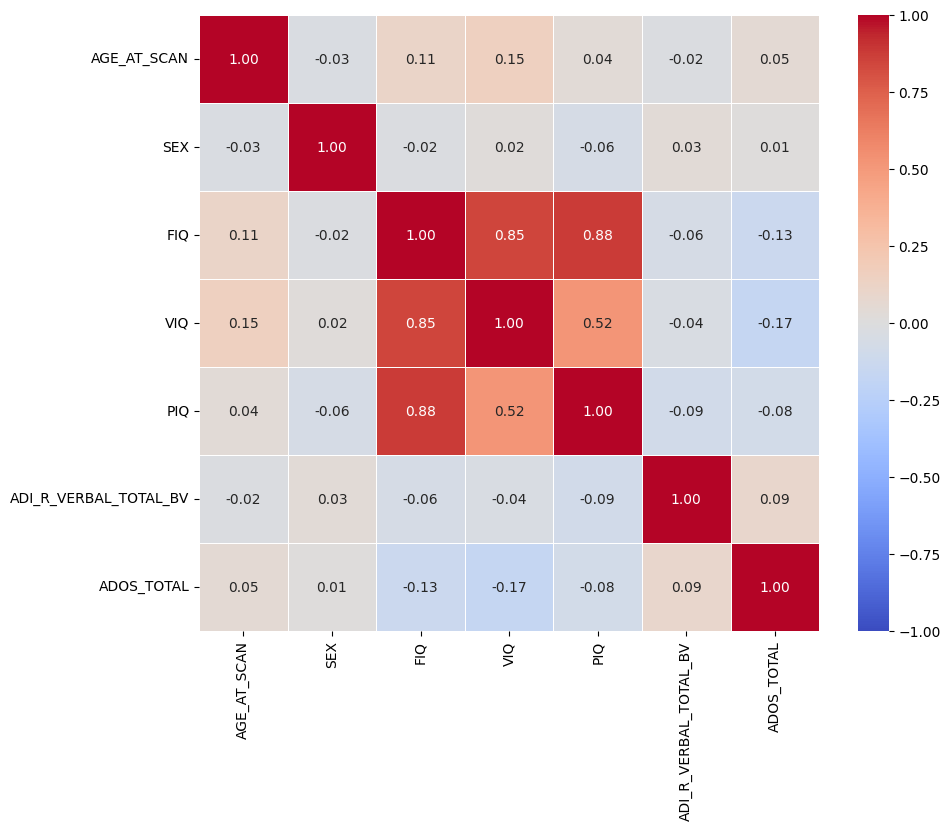

In [36]:
correlation_matrix = numeric_normalized.corr()
numeric_normalized.T
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(numeric_normalized.corr(), 
            annot=True, 
            linewidths=.5, 
            fmt= '.2f',
            ax=ax,
            vmin=-1, 
            vmax=1,
            cmap = "coolwarm")
plt.show()


## Correlation between Categorical Features

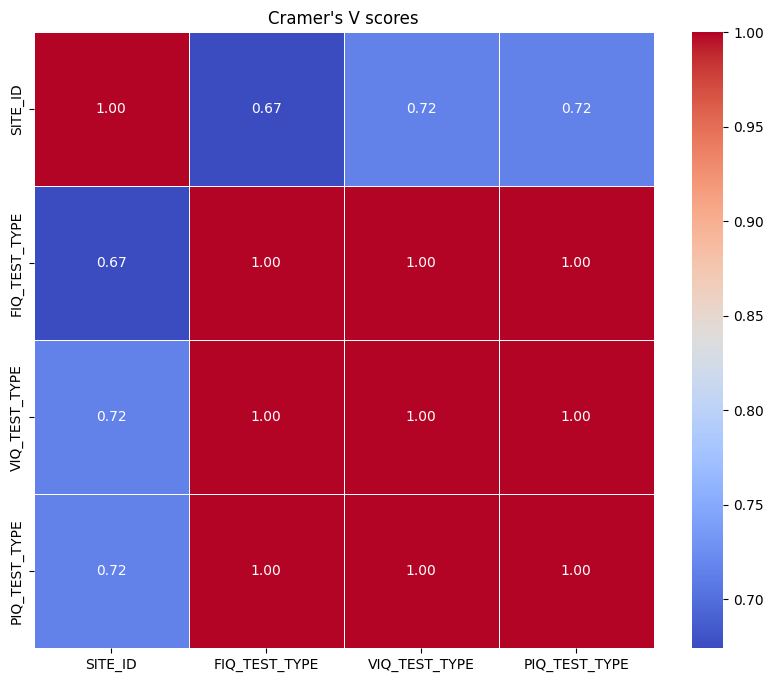

In [37]:
numeric_columns, categorical_columns, ASD_phenotypic_normalized = of.select_columns(ASD_phenotypic_normalized)
# Compute Cramer's V for every pair of features
cramer_v_scores = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
for feature1 in categorical_columns:
    for feature2 in categorical_columns:
        cramer_v = of.cramers_v(ASD_phenotypic_normalized[feature1], ASD_phenotypic_normalized[feature2])
        cramer_v_scores.loc[feature1, feature2] = cramer_v

# Plot heatmap of Cramer's V scores
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_v_scores.astype(float), 
            annot=True, 
            linewidths=.5, 
            fmt='.2f',
            cmap="coolwarm")
plt.title("Cramer's V scores")
plt.show()


It seems that the information contained in FIQ_TEST_TYPE, VIQ_TEST_TYPE and PIQ_TEST_TYPE is almost the same, so it's reasonable thinking to eliminate from our analysis some of them.
In particular, since the relation between them:
Test Type
- PIQ-FIQ = 1
- VIQ-FIQ = 1
- PIQ-VIQ = 1
Thus, we procced keeping in consideration only PIQ_Test_Type (Performance Intelligence Quotient)  also for the presence of Ravens test type, that has a significant use in ASD investigation. The others test_type cosidarated relevant are shared between them.

In [38]:
ASD_phenotypic_normalized = ASD_phenotypic_normalized.drop(columns=['VIQ_TEST_TYPE', 'FIQ_TEST_TYPE'])
ASD_phenotypic = ASD_phenotypic.drop(columns=['VIQ_TEST_TYPE', 'FIQ_TEST_TYPE'])


### Visual "correlation" between Categorical and Numerical Features

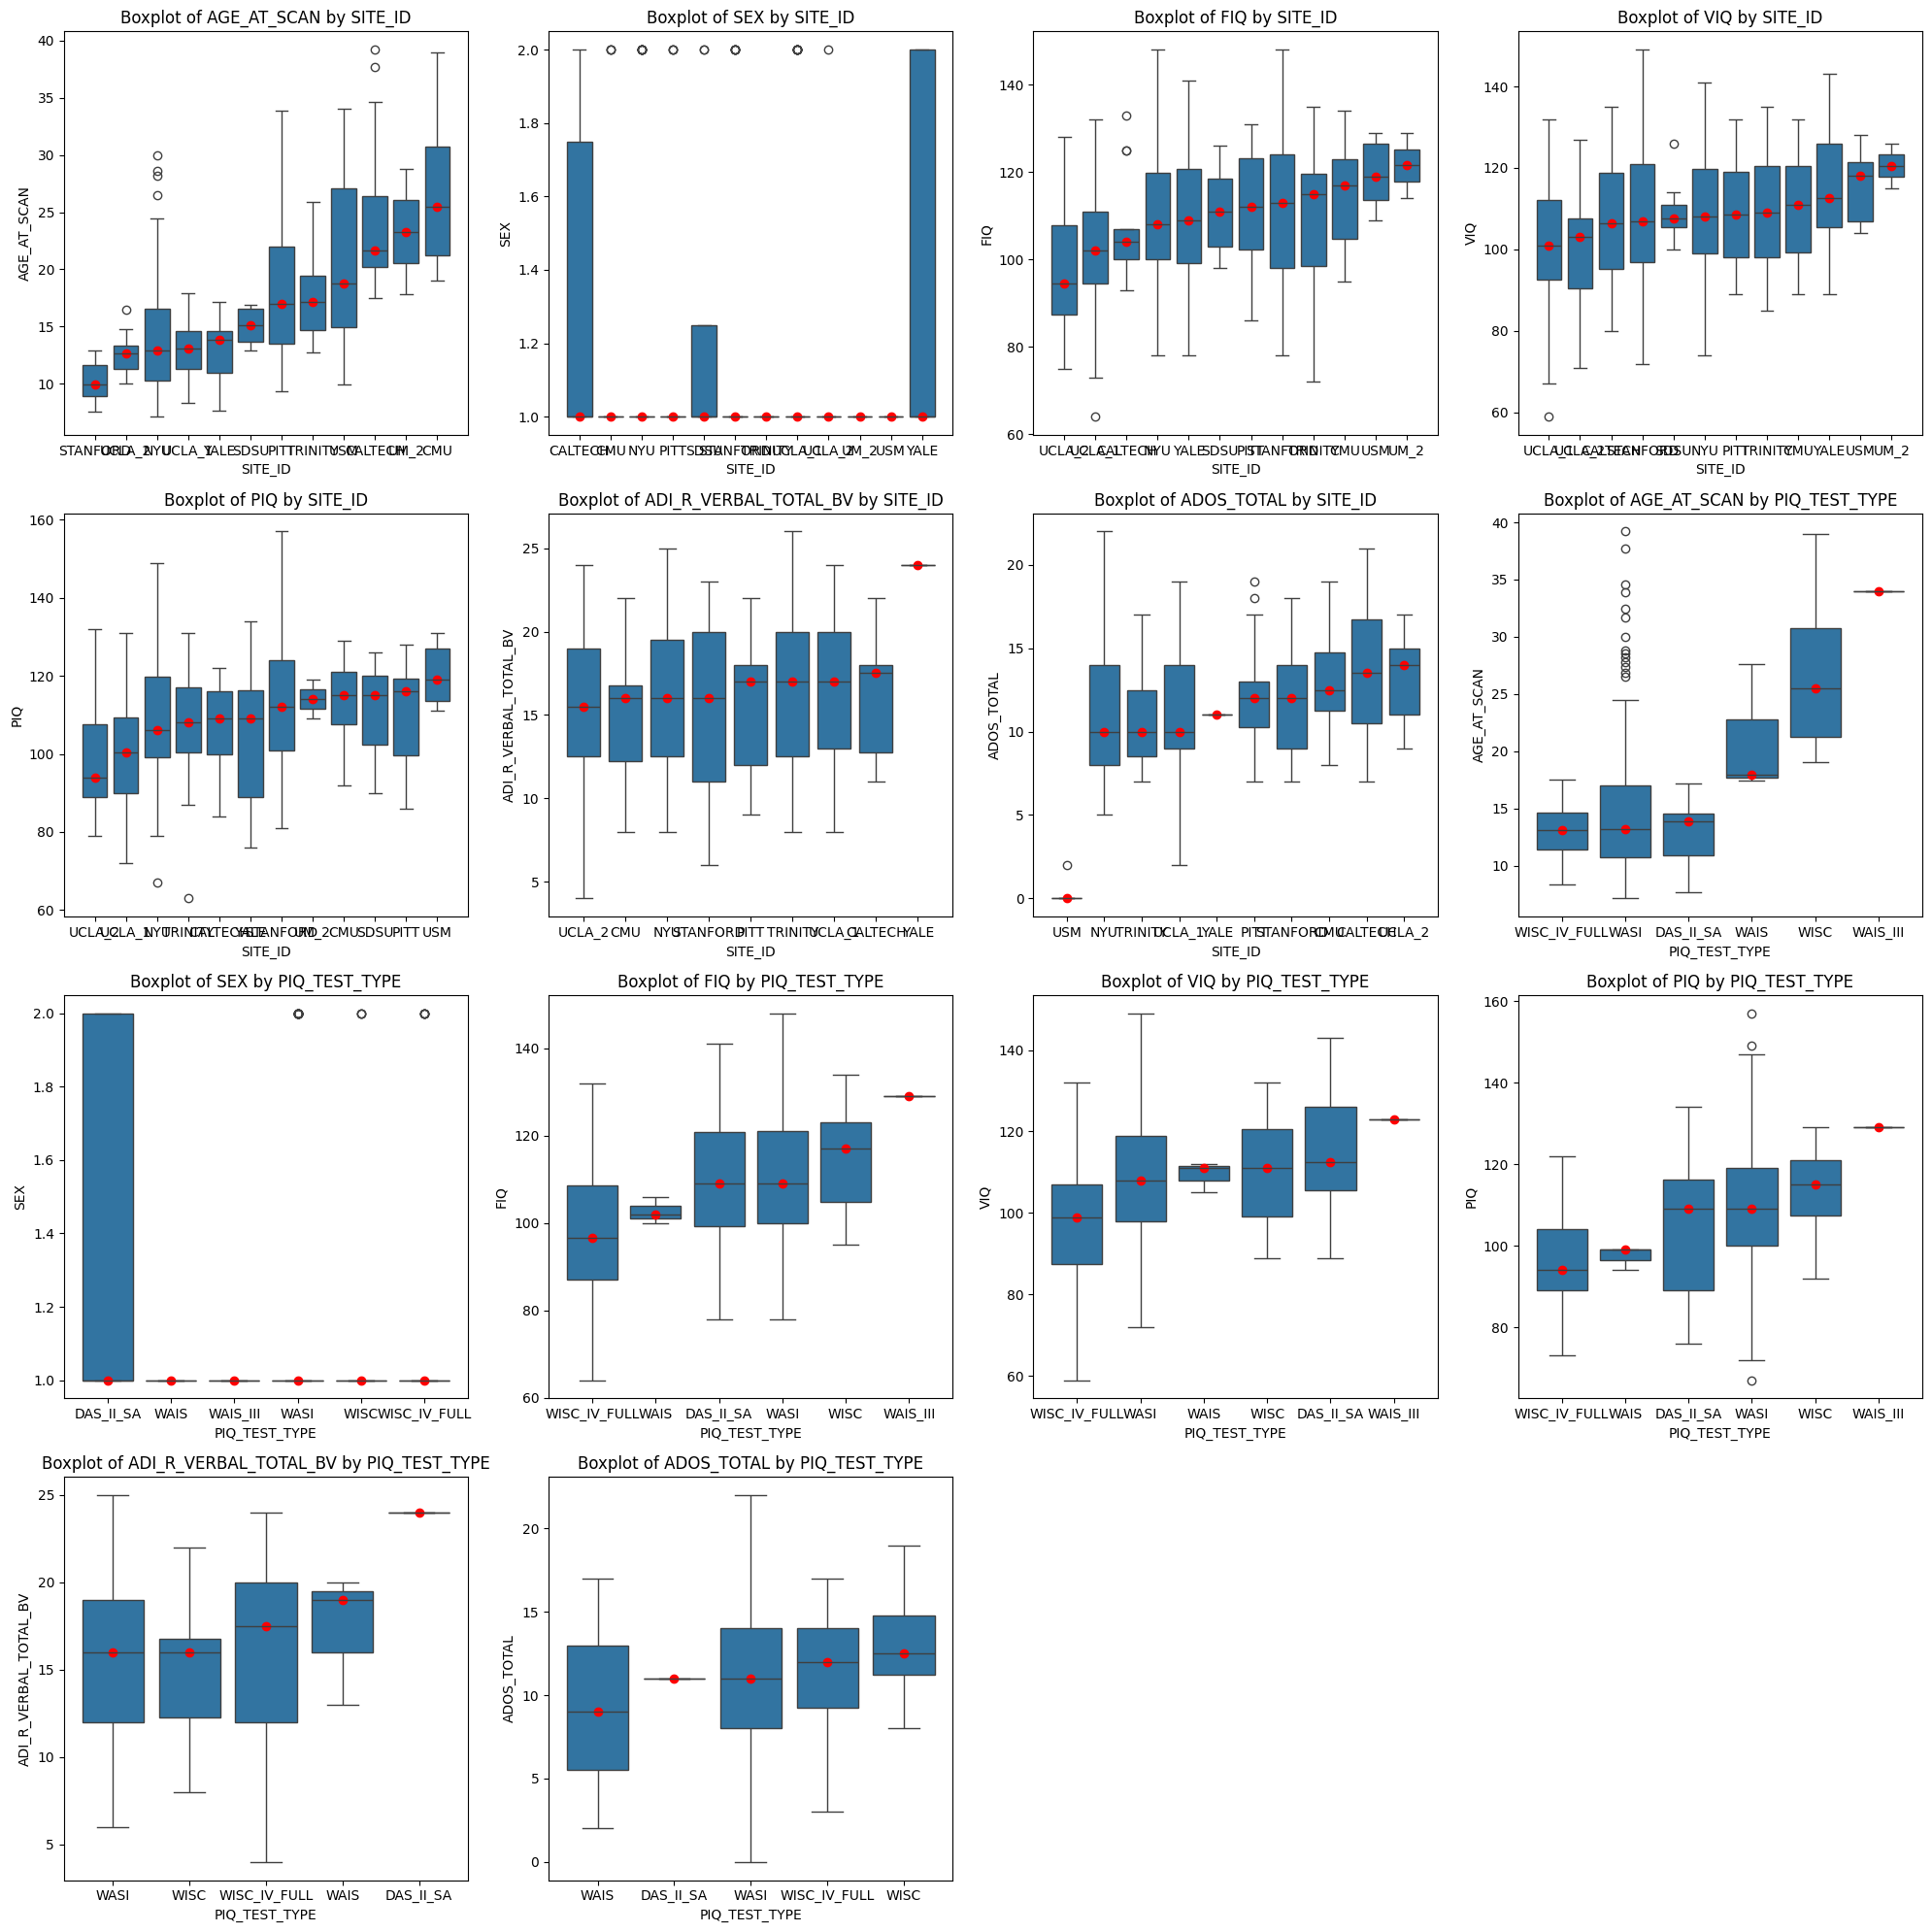

In [39]:

numeric_columns, _, _ = of.select_columns(ASD_phenotypic)

# Definire le due feature categoriche specifiche in ordine desiderato
categorical_columns = ['SITE_ID', 'PIQ_TEST_TYPE']

# Number of plots per row
plots_per_row = 4
num_plots = len(numeric_columns) * len(categorical_columns)
num_rows = (num_plots + plots_per_row - 1) // plots_per_row  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, num_rows * 5))

# Flatten axes for easy iteration
axes = axes.flatten()

plot_idx = 0
for cat_col in categorical_columns:
    for numeric_col in numeric_columns:
        ax = axes[plot_idx]
        
        sns.boxplot(x=cat_col, y=numeric_col, data=ASD_phenotypic,
                    order=ASD_phenotypic_normalized.groupby(cat_col, observed=False)[numeric_col].median().sort_values().index, ax=ax)
        
        # Highlight the median in red
        median = ASD_phenotypic.groupby(cat_col, observed=False)[numeric_col].median().sort_values()
        for i in range(len(median)):
            ax.plot(i, median.iloc[i], 'ro')
        
        ax.set_title(f'Boxplot of {numeric_col} by {cat_col}')
        ax.set_xlabel(cat_col)
        ax.set_ylabel(numeric_col)
        
        plot_idx += 1

# Remove any empty subplots
for i in range(plot_idx, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


We notice that it could be possible dealing with a Site-Specific or Test-Specific Analysis.
However, at the moment, it is out of scope. We leave the possibility to proceed on these different lines in further investigations.
Thus, we may decide to drop the feature SITE_ID.

#  DATA PREPROCESSING

First of all, in order to avoid mismatch between attributes that are the same, but written with upper or lower characters, we decide to unify them.

In [40]:
#We make all the caracters upper for all the categorical features
category_columns_upper = ASD_phenotypic.select_dtypes(include='category').apply(lambda x: x.str.upper())

#We now modify them in the dataset
ASD_phenotypic[category_columns_upper.columns] = category_columns_upper

In [41]:
numeric_columns, categorical_columns, ASD_phenotypic = of.select_columns(ASD_phenotypic)


In [42]:
# We obtain the names of the features 
categorical_column_names = categorical_columns.tolist()
categorical_column_names

['SITE_ID', 'PIQ_TEST_TYPE']

## Exploiting categorical features

### SITE_ID

SITE_ID refers to the place where the data have benne collected

In [43]:
# Accesso a una specifica colonna categorica utilizzando la lista di nomi
specific_category_column = ASD_phenotypic[categorical_column_names[0]].value_counts(dropna=False)
specific_category_column


SITE_ID
NYU         94
UCLA_1      60
PITT        28
STANFORD    25
TRINITY     23
UCLA_2      18
CALTECH     14
CMU         14
YALE        12
SDSU         8
USM          7
UM_2         2
Name: count, dtype: int64

There is data that has been collected from the same center that we decide to unify.

In [44]:
# We create a function to replace the categories for the indicated cases

def replace_categories(category):
    if "UCLA" in category:
        return "UCLA"
    if "LEUVEN" in category:
        return "LEUVEN"
    if "UM" in category:
        return "UM"
    else:
        return category

# Then we apply the replace function
ASD_phenotypic[categorical_column_names[0]] = ASD_phenotypic[categorical_column_names[0]].apply(replace_categories).astype('category')

# Now we check the new order
specific_category_column = ASD_phenotypic[categorical_column_names[0]].value_counts(dropna=False)
specific_category_column

SITE_ID
NYU         94
UCLA        78
PITT        28
STANFORD    25
TRINITY     23
CALTECH     14
CMU         14
YALE        12
SDSU         8
USM          7
UM           2
Name: count, dtype: int64

### PIQ_TEST_TYPE 

PIQ_TEST_TYPE refer to the type of test that each center chose to use. 


In [45]:
specific_category_column = ASD_phenotypic[categorical_column_names[1]].value_counts(dropna=False)
specific_category_column

PIQ_TEST_TYPE
WASI            205
WISC_IV_FULL     47
NaN              23
WISC             14
DAS_II_SA        12
WAIS              3
WAIS_III          1
Name: count, dtype: int64

In [46]:
# We create a function to replace the categories for the indicated cases

def replace_categories(category):
    if pd.isna(category):  # Controlla se il valore è NaN
        return category  # Se è NaN, restituisci lo stesso valore
    if "WASI" in category:
        return "WASI"
    if "WISC" in category:
        return "WISC"
    if "WAIS" in category:
        return "WAIS"
    if "DAS" in category:
        return "DAS"
    if "HAWIK" in category:
        return "HAWIK"
    if "PPVT" in category:
        return "PPVT"
    if "RAVENS" in category:
        return "RAVENS"
   
    else:
        return category


ASD_phenotypic[categorical_column_names[1]] = ASD_phenotypic[categorical_column_names[1]].apply(replace_categories).astype('category')
specific_category_column = ASD_phenotypic[categorical_column_names[1]].value_counts(dropna=False)
print(specific_category_column)



PIQ_TEST_TYPE
WASI    205
WISC     61
NaN      23
DAS      12
WAIS      4
Name: count, dtype: int64


## Managing Missing Values

Now we are going to fullfill the missing values for all the features, based on an analysis of the information delivered by each one.

### IQ Test Type

We use features FIQ, VIQ and PIQ in order to fill some values in PIQ-TEST-TYPE.
Since the presence of more missing values in "Type" features, we make a comparison for each couple of features. For instance: if for PIQ there is a value and for PIQ-TEST-TYPE there is a missing one, we fill it with the MODE.

In [47]:
# Features pairs to be checked 
feature_pairs = [
    ('FIQ_TEST_TYPE', 'FIQ'),
    ('PIQ_TEST_TYPE', 'PIQ'),
    ('VIQ_TEST_TYPE', 'VIQ')]

# Itering on each pair of features
for test_type_col, score_col in feature_pairs:
    if test_type_col not in ASD_phenotypic.columns:
        test_type_df = ASD_phenotypic_original
    else:
        test_type_df = ASD_phenotypic
    # Itering on each row DataFrame
    for index, row in test_type_df.iterrows():
        # Check if the value of 'test_type_col' is missed
        if pd.isnull(row[test_type_col]):
            # If the value of column 'score_col' is present
            if not pd.isnull(row[score_col]):
                # Calculate mode of 'test_type_col'
                mode_test_type = test_type_df[test_type_col].mode()[0]
                # Substituing 'test_type_col' missing value with the mode 
                test_type_df.at[index, test_type_col] = mode_test_type
            # If both values in 'test_type_col' e 'score_col' are missing
            elif pd.isnull(row[score_col]):
                # Verify if is "NOT_AVAILABLE" is already present between categories of columns
                if "NOT_AVAILABLE" not in test_type_df[test_type_col].cat.categories:
                    # Add "NOT_AVAILABLE" as new category
                    test_type_df[test_type_col] = test_type_df[test_type_col].cat.add_categories("NOT_AVAILABLE")
                # Assigning category 'NOT_AVAILABLE' to 'test_type_col'
                test_type_df.at[index, test_type_col] = 'NOT_AVAILABLE'


### Test Scores

##### Data Standarization

Before starting to fill the missing values, we note that as the data for the variables FIQ, VIQ, PIQ was obtained with different tests, there are also different scales for the scores to take into account. In this way, we prefer to apply a standardization so we have all the score on the same scale.


In [48]:
ASD_phenotypic

,SITE_ID,AGE_AT_SCAN,SEX,FIQ,VIQ,PIQ,PIQ_TEST_TYPE,ADI_R_VERBAL_TOTAL_BV,ADOS_TOTAL
1,CALTECH,22.90,1,107.0,119.0,93.0,WASI,17.0,8.0
2,CALTECH,39.20,1,93.0,80.0,108.0,WASI,18.0,20.0
3,CALTECH,22.80,1,106.0,94.0,118.0,WASI,12.0,12.0
4,CALTECH,34.60,2,133.0,135.0,122.0,WASI,11.0,13.0
5,CALTECH,37.70,1,99.0,111.0,84.0,WASI,15.0,9.0
...,...,...,...,...,...,...,...,...,...
1077,YALE,15.75,2,105.0,126.0,82.0,DAS,NaN,NaN
1078,YALE,14.17,1,103.0,92.0,103.0,DAS,NaN,NaN
1080,YALE,14.00,1,120.0,127.0,114.0,DAS,NaN,NaN
1081,YALE,8.42,2,119.0,112.0,120.0,DAS,NaN,NaN


In [49]:
ASD_phenotypic_copy = ASD_phenotypic.copy()
ASD_phenotypic_copy['SUB_ID'] = ASD_phenotypic_original['SUB_ID']


In [50]:
#For FIQ, the score scale is between 30-170 if the test taken was "DAS", otherwise is 50-160.
#We will unify all the data to the larger scale, i.e. 50-160

present_subjects = set(ASD_phenotypic_copy['SUB_ID'])
#Dataset original but only with actual subjects (present in ASD_phenotypic)
filtered_original = ASD_phenotypic_original[ASD_phenotypic_original['SUB_ID'].isin(present_subjects)]


In [51]:
# We start defining the condition
condition = (filtered_original['FIQ_TEST_TYPE'] == 'DAS') | (ASD_phenotypic['FIQ'] < 50) | (ASD_phenotypic['FIQ'] > 160)

# Then we standarize the values dictated by the condition, to the new scale
ASD_phenotypic['FIQ'] = np.where(condition, 
                        (ASD_phenotypic['FIQ'] - 30) / (170 - 30) * (160 - 50) + 50, 
                        ASD_phenotypic['FIQ'])

In [52]:
#For VIQ, the score scale is between 31-169 if the test taken was "DAS", 
#between 36-164 if the test taken was "STANFORD",
 #between 40-160 if the test taken was "PPVT",  otherwise is 50-160.
#We will unify all the data to the more common used scale, i.e. 50-160

for i in ASD_phenotypic.index:
    test_type = filtered_original['VIQ_TEST_TYPE'][i]
    current_value = ASD_phenotypic['VIQ'][i]
    if (test_type == 'DAS') or (current_value <36) or (current_value > 164):
        ASD_phenotypic.loc[i, 'VIQ'] = (current_value - 31) / (169 - 31) * (160 - 50) + 50
    elif (test_type == 'STANFORD') or (current_value <40) or (current_value > 160):
        ASD_phenotypic.loc[i, 'VIQ'] = (current_value - 36) / (164 - 36) * (160 - 50) + 50
    elif (test_type == 'PPVT') or (current_value <50) or (current_value > 160):
        ASD_phenotypic.loc[i, 'VIQ'] = (current_value - 40) / (160 - 40) * (160 - 50) + 50


In [53]:
#For PIQ, the score scale is between 31-166 if the test taken was "DAS", 
#between 36-164 if the test taken was "STANFORD",
 #between 50-160 if the test taken was "RAVENS",  otherwise is 53-160.
#We will unify all the data to the more common used scale,, i.e. 50-160

for i in ASD_phenotypic.index:
    test_type = ASD_phenotypic['PIQ_TEST_TYPE'][i]
    current_value = ASD_phenotypic['PIQ'][i]
    if (test_type == 'DAS') or (current_value <36) or (current_value > 164):
        ASD_phenotypic.loc[i, 'VIQ'] = (current_value - 31) / (166 - 31) * (160 - 50) + 50
    elif (test_type == 'STANFORD') or (current_value <50) or (current_value > 160):
        ASD_phenotypic.loc[i, 'VIQ'] = (current_value - 36) / (164 - 36) * (160 - 50) + 50


In [54]:
ASD_phenotypic.describe()

,AGE_AT_SCAN,SEX,FIQ,VIQ,PIQ,ADI_R_VERBAL_TOTAL_BV,ADOS_TOTAL
count,305.000000,305.000000,304.000000,305.000000,305.000000,229.000000,235.000000
mean,15.437385,1.131148,108.315789,107.347905,107.308197,16.004367,11.357447
std,6.113938,0.338116,15.560770,15.300327,15.693511,4.439158,4.110636
min,7.130000,1.000000,64.000000,59.000000,63.000000,4.000000,0.000000
25%,11.160000,1.000000,98.000000,98.000000,96.000000,12.000000,9.000000
50%,13.809700,1.000000,108.000000,108.000000,108.000000,16.000000,11.000000
75%,17.780000,1.000000,119.000000,119.000000,119.000000,20.000000,14.000000
max,39.200000,2.000000,148.000000,149.000000,157.000000,26.000000,22.000000


### ADOS_TOTAL

The feature "ADOS_TOTAL" is simply the sum of the scores obtained by "ADOS_COMM" and "ADOS_SOCIAL", so we can reduce the amount of missing values using the values of those features.

In [55]:
# Replace -9999 and "-9999" with NaN
ASD_phenotypic_original["ADOS_COMM"] = ASD_phenotypic_original["ADOS_COMM"].replace(['-9999', -9999], np.NaN)
ASD_phenotypic_original["ADOS_SOCIAL"] = ASD_phenotypic_original["ADOS_SOCIAL"].replace(['-9999', -9999], np.NaN)

for i in ASD_phenotypic["ADOS_TOTAL"].index:
    ados_comm = ASD_phenotypic_original["ADOS_COMM"][i]
    ados_social = ASD_phenotypic_original["ADOS_SOCIAL"][i]
    if not pd.isna(ados_comm) and not pd.isna(ados_social):
        ASD_phenotypic.loc[i, "ADOS_TOTAL"] = ados_comm + ados_social
    

#### Test scores filling

We decided that to fill the missing values of the test subministred
it should be good to rely on the standard score achieved by the mean
of the global population (if the statistics are available in the literature) or the cutoff for the diagnostic of ASD,
otherwise we will use the mean extracted from our dataset.

So for the features "FIQ", "VIQ", "PIQ", "ADOS_TOTAL", "ADI_R_VERBAL_TOTAL_BV", we will apply a custom function that checks if there is an available value in literature for the mundial mean, otherwise assign the mean of the feature.


In [56]:
#list of features that we want to fill
test_score_fatures = ["FIQ", "VIQ", "PIQ", "ADOS_TOTAL", "ADI_R_VERBAL_TOTAL_BV"]

#function to fill with the global mean or the data feature mean
def test_score_fill (feature_value, feature_name, feature_mean):
    # We create a dictionary to store the literature mean scores
    literature_scores = {
    "FIQ": list(range(95, 100)), # EEUU, mean score retrieved from https://www.worlddata.info/iq-by-country.php
    "VIQ": list(range(95, 100)), # EEUU, mean score retrieved from https://www.worlddata.info/iq-by-country.php
    "PIQ": list(range(95, 100)), # EEUU, mean score retrieved from https://www.worlddata.info/iq-by-country.php
    "ADOS_TOTAL": list(range(6, 12)), # autism cutoff retrieved from https://www.researchgate.net/figure/ADOS-maximum-score-and-cut-off-points-for-ASD-15_tbl1_361212648
    "ADI_R_VERBAL_TOTAL_BV": list(range(7, 10)), # autism cutoff retrieved from https://www.researchgate.net/figure/Summary-statistics-for-ADI-R-domain-scores_tbl4_6709395
    }

    # Then we check which feature we obtained to decide if replace
    # using the value in the dictionary ot directly the mean of the data
    if pd.isna(feature_value):

        if feature_name in literature_scores:
            return random.choice(literature_scores[feature_name])
        else:
            return feature_mean
    else:

        return feature_value

#loop for filling the features   
for feature_name in test_score_fatures:
    feature_mean = ASD_phenotypic_original[feature_name].mean()
    ASD_phenotypic[feature_name] = ASD_phenotypic[feature_name].apply(test_score_fill, args=(feature_name, feature_mean))


In [57]:
ASD_phenotypic.describe()

,AGE_AT_SCAN,SEX,FIQ,VIQ,PIQ,ADI_R_VERBAL_TOTAL_BV,ADOS_TOTAL
count,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000
mean,15.437385,1.131148,108.275410,107.347905,107.308197,13.996721,10.698361
std,6.113938,0.338116,15.551153,15.300327,15.693511,5.206586,3.890884
min,7.130000,1.000000,64.000000,59.000000,63.000000,4.000000,0.000000
25%,11.160000,1.000000,98.000000,98.000000,96.000000,9.000000,8.000000
50%,13.809700,1.000000,108.000000,108.000000,108.000000,14.000000,10.000000
75%,17.780000,1.000000,119.000000,119.000000,119.000000,18.000000,13.000000
max,39.200000,2.000000,148.000000,149.000000,157.000000,26.000000,22.000000


We can see, that if we display the information of the dataset, we have no longer presence of missing values.

In [58]:

ASD_phenotypic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305 entries, 1 to 1090
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   SITE_ID                305 non-null    category
 1   AGE_AT_SCAN            305 non-null    float64 
 2   SEX                    305 non-null    int64   
 3   FIQ                    305 non-null    float64 
 4   VIQ                    305 non-null    float64 
 5   PIQ                    305 non-null    float64 
 6   PIQ_TEST_TYPE          305 non-null    category
 7   ADI_R_VERBAL_TOTAL_BV  305 non-null    float64 
 8   ADOS_TOTAL             305 non-null    float64 
dtypes: category(2), float64(6), int64(1)
memory usage: 28.3 KB


In [59]:
ASD_phenotypic.isnull().sum()

SITE_ID                  0
AGE_AT_SCAN              0
SEX                      0
FIQ                      0
VIQ                      0
PIQ                      0
PIQ_TEST_TYPE            0
ADI_R_VERBAL_TOTAL_BV    0
ADOS_TOTAL               0
dtype: int64

# Data distribution

We want to check if filling Missing Values has affected the data distribution

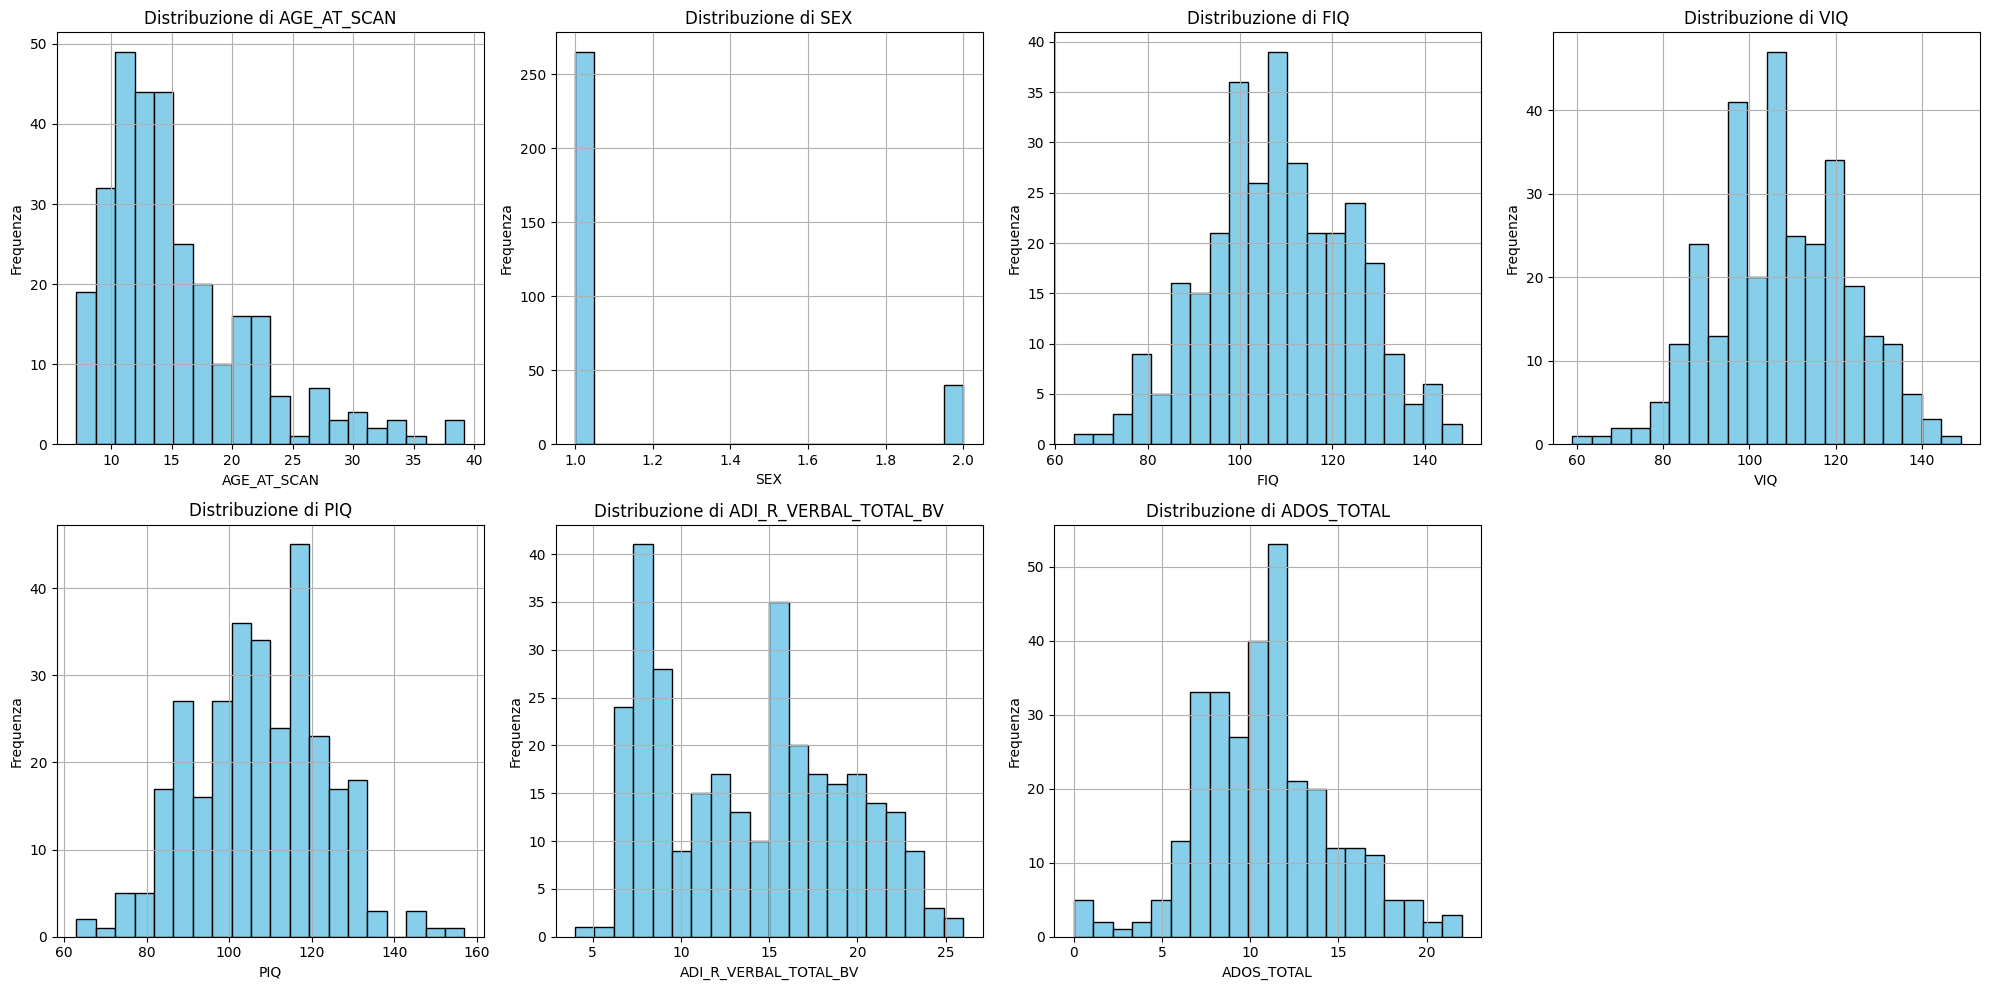

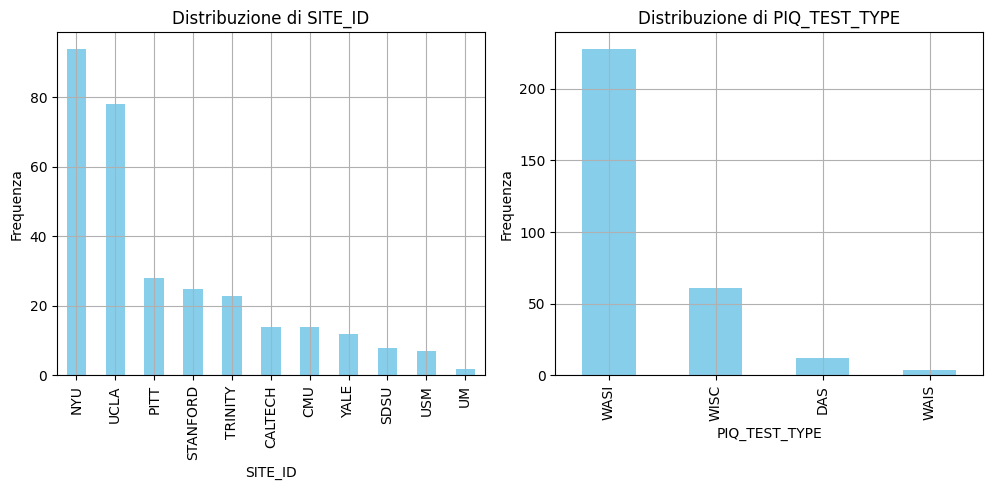

In [60]:
# Utilizzo della funzione per plottare le distribuzioni delle features
of.plot_distributions(ASD_phenotypic)

At the end, after have worked on SITE_IT feature in order to have a better preparation for possible future works, we decide to drop it.

In [61]:
ASD_phenotypic = ASD_phenotypic.drop(columns=["SITE_ID"])

# PRE PROCESSED DATA STORAGE

In [62]:

# We decide to store in a file .csv the pre-processed dataset
ASD_phenotypic.to_csv('DataSets/Phenotypic Datasets/ASD_phenotypic_preprocessed.csv', index=False)
# And also the diagnostic groups
ASD_clinical.to_csv('DataSets/Phenotypic Datasets/ASD_clinical.csv', index=False)
